# myChemometrix

#### import packages

In [1261]:
import os
import sys
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, KFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from scipy.stats import f
import numpy as np
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (12, 6)

### Import Data File (csv, xlsx)

In [1262]:
file_path = (os.getcwd() + '/data/spectra CE801-2-3-11-12-16 out.xlsx')
# print('file path:', file_path)

### Save data as Pandas Dataframe

In [1263]:
if file_path.endswith('.csv'):
    df_raw = pd.read_csv(file_path, encoding='utf-8')
elif file_path.endswith('.xlsx'):
    df_raw = pd.read_excel(file_path)

### Inspect Raw Data

In [1264]:
print(f'Number of rows: {df_raw.shape[0]} \nNumber of columns: {df_raw.shape[1]}')

print('\nDisplay the first 5 rows of the data:')
display(df_raw.head(5))

Number of rows: 2010 
Number of columns: 114

Display the first 5 rows of the data:


,DateTime,spec #,SpecName,FluidT,SpectrT,ExpTime,start time,end time,test #,H2O2,...,1036,1038.5,1041,1043.5,1046,1048.5,1051,1053.5,1056,1058.5
0,2024-05-07 11:08:05,1,S7244,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,2024-05-07 11:08:11,2,S7245,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,2024-05-07 11:08:17,3,S7246,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,2024-05-07 11:08:23,4,S7247,23.10,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,2024-05-07 11:08:29,5,S7248,23.10,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


#### Remove non-numerical columns

In [1265]:
df_raw = df_raw.select_dtypes(include=['number'])
df_raw.head(5)

,spec #,FluidT,SpectrT,ExpTime,test #,H2O2,Cu,pH,A,H2O,...,1036,1038.5,1041,1043.5,1046,1048.5,1051,1053.5,1056,1058.5
0,1,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,2,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,3,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,4,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,5,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


### Check for empty cells and remove if exist

In [1266]:
flag_na = df_raw.isnull().any().any()

print(f'Any empty cells in DataFrame: {flag_na}')

if flag_na:
    df_raw = df_raw.dropna()    
    print(f'Number of rows: {df_raw.shape[0]} \nNumber of columns: {df_raw.shape[1]}')
    print('\nDisplay the first 5 rows of the data:')
    display(df_raw.head(5))

Any empty cells in DataFrame: True
Number of rows: 1877 
Number of columns: 110

Display the first 5 rows of the data:


,spec #,FluidT,SpectrT,ExpTime,test #,H2O2,Cu,pH,A,H2O,...,1036,1038.5,1041,1043.5,1046,1048.5,1051,1053.5,1056,1058.5
0,1,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,2,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,3,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,4,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,5,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


## Remove bad measurements

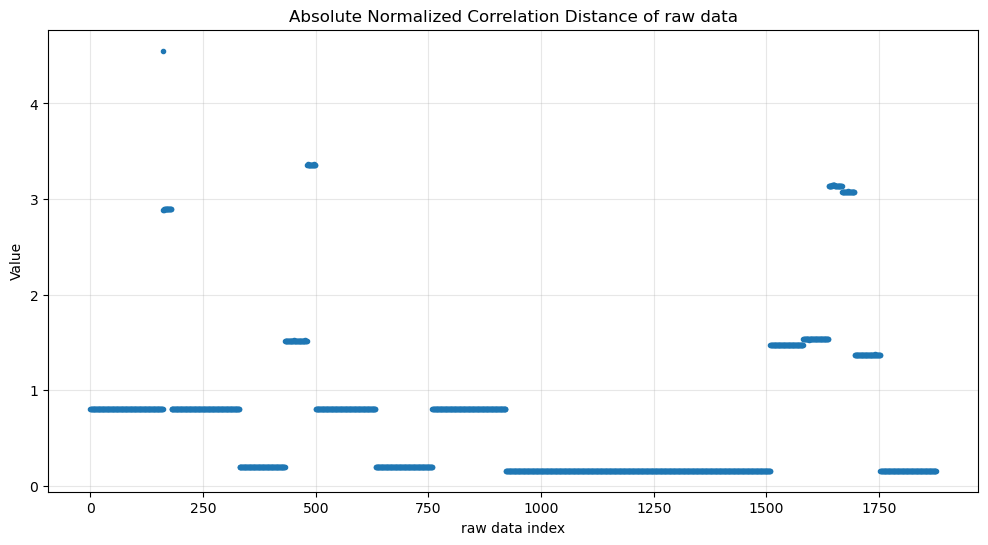

In [1267]:
dissimilarities = cdist(df_raw.iloc[:, 10:], df_raw.iloc[:, 10:], metric="correlation")
absolute_normalized_dissimilarities_vector = (np.abs((dissimilarities[1] - np.mean(dissimilarities[1])) / np.std(dissimilarities[1])))

plt.plot(df_raw.index, absolute_normalized_dissimilarities_vector, '.')
plt.title('Absolute Normalized Correlation Distance of raw data')
plt.xlabel('raw data index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

In [1268]:
corr_dist_threshold_high = 4
corr_dist_threshold_low = 0

high_lim_rows_to_remove = np.where((absolute_normalized_dissimilarities_vector > corr_dist_threshold_high))[0]
low_lim_rows_to_remove = np.where((absolute_normalized_dissimilarities_vector < corr_dist_threshold_low))[0]

rows_to_remove = list(high_lim_rows_to_remove) + list(low_lim_rows_to_remove)

print(f'Rows to remove from data: {rows_to_remove}')

Rows to remove from data: [161]


In [1269]:
df_raw = df_raw.drop(index=rows_to_remove)
print(f'Number of rows remained: {df_raw.shape[0]}')

Number of rows remained: 1876


### Equalize the data grouped by a label while keeping the distrabution of the measurements

In [1270]:
group_by = 'H2O'

def equalize_group_size(df, group_column):
    # Group the DataFrame according to the specific column
    grouped = df.groupby(group_column)
    
    # Determine the size of the smallest group
    min_group_size = grouped.size().min()
    
    # Sample data from each group to make them the same size
    equalized_data = []
    for _, group_data in grouped:
        equalized_data.append(group_data.sample(n=min_group_size, random_state=None))
    
    # Concatenate the sampled data into a new DataFrame
    equalized_df = pd.concat(equalized_data)
    
    return equalized_df


def equalize_group_size_by_padding_mean(df, group_column):
    # Group the DataFrame according to the specific column
    grouped = df.groupby(group_column)
    
    # Determine the size of the largest group
    max_group_size = grouped.size().max()
    
    # List to hold the equalized data
    equalized_data = []
    
    for name, group_data in grouped:
        group_size = len(group_data)
        
        # Append the original group data
        equalized_data.append(group_data)
        
        # Calculate the number of rows to pad
        rows_to_add = max_group_size - group_size
        
        if rows_to_add > 0:
            # Calculate the mean values for the group's columns
            mean_values = group_data.mean()
            
            # Create a DataFrame with the mean values to pad the group
            padding_df = pd.DataFrame([mean_values] * rows_to_add, columns=group_data.columns)
            
            # Set the group column to the current group's name
            padding_df[group_column] = name
            
            # Append the padding data
            equalized_data.append(padding_df)
    
    # Concatenate the original and padded data into a new DataFrame
    equalized_df = pd.concat(equalized_data, ignore_index=True)
    
    return equalized_df

def equalize_group_size_by_padding_mean_std(df, group_column, noise_gain):
    # Group the DataFrame according to the specific column
    grouped = df.groupby(group_column)
    
    # Determine the size of the largest group
    max_group_size = grouped.size().max()
    
    # List to hold the equalized data
    equalized_data = []
    
    for name, group_data in grouped:
        group_size = len(group_data)
        
        # Append the original group data
        equalized_data.append(group_data)
        
        # Calculate the number of rows to pad
        rows_to_add = max_group_size - group_size
        
        if rows_to_add > 0:
            # Calculate the mean and std values for the group's columns
            mean_values = group_data.mean()
            std_values = noise_gain * group_data.std()
            
            # Create new rows with mean + random value between -std and +std
            padding_data = {col: np.random.uniform(mean - std, mean + std, rows_to_add) 
                            for col, mean, std in zip(group_data.columns, mean_values, std_values)}
            padding_df = pd.DataFrame(padding_data)
            
            # Set the group column to the current group's name
            padding_df[group_column] = name
            
            # Append the padding data
            equalized_data.append(padding_df)
    
    # Concatenate the original and padded data into a new DataFrame
    equalized_df = pd.concat(equalized_data, ignore_index=True)
    
    return equalized_df

# Equalize group size while preserving distribution
# df_raw = equalize_group_size(df_raw, group_by).reset_index(drop=True)
# df_raw = equalize_group_size_by_padding_mean(df_raw, group_by).reset_index(drop=True)
# df_raw = equalize_group_size_by_padding_mean_std(df_raw, group_by, 1).reset_index(drop=True)

In [1271]:
df_raw.shape

(1876, 110)

### Seperate raw data to features matrix X and targets matrix y 

* Features matrix X

1. list numeric headers from the raw dataframe

In [1272]:
# Check if the column headers are numeric
numeric_columns = [col for col in df_raw.columns if isinstance(col, (int, float))]

print(f'list of numeric headers:\n{numeric_columns}')

list of numeric headers:
[811, 813.5, 816, 818.5, 821, 823.5, 826, 828.5, 831, 833.5, 836, 838.5, 841, 843.5, 846, 848.5, 851, 853.5, 856, 858.5, 861, 863.5, 866, 868.5, 871, 873.5, 876, 878.5, 881, 883.5, 886, 888.5, 891, 893.5, 896, 898.5, 901, 903.5, 906, 908.5, 911, 913.5, 916, 918.5, 921, 923.5, 926, 928.5, 931, 933.5, 936, 938.5, 941, 943.5, 946, 948.5, 951, 953.5, 956, 958.5, 961, 963.5, 966, 968.5, 971, 973.5, 976, 978.5, 981, 983.5, 986, 988.5, 991, 993.5, 996, 998.5, 1001, 1003.5, 1006, 1008.5, 1011, 1013.5, 1016, 1018.5, 1021, 1023.5, 1026, 1028.5, 1031, 1033.5, 1036, 1038.5, 1041, 1043.5, 1046, 1048.5, 1051, 1053.5, 1056, 1058.5]


 2. remove unwanted columns if needed

In [1273]:
# uncomment if removing is needed

# # Values to remove
# values_to_remove = [811, 986]

# # Create a new list excluding the values to remove
# numeric_columns = [item for item in numeric_columns if item not in values_to_remove]

selected_x_columns = numeric_columns

3. create features matrix X

In [1274]:
X = df_raw[selected_x_columns]
print(f'Number of rows: {X.shape[0]} \nNumber of columns: {X.shape[1]}')
print('\nDisplay the first 5 rows of the data:')
display(X.head(5))

Number of rows: 1876 
Number of columns: 100

Display the first 5 rows of the data:


,811.0,813.5,816.0,818.5,821.0,823.5,826.0,828.5,831.0,833.5,...,1036.0,1038.5,1041.0,1043.5,1046.0,1048.5,1051.0,1053.5,1056.0,1058.5
0,-0.016455,-0.016218,-0.015843,-0.015277,-0.014390,-0.013066,-0.011343,-0.009393,-0.007441,-0.005761,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,-0.016460,-0.016223,-0.015847,-0.015279,-0.014391,-0.013067,-0.011345,-0.009394,-0.007442,-0.005759,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,-0.016467,-0.016231,-0.015856,-0.015289,-0.014400,-0.013075,-0.011353,-0.009402,-0.007448,-0.005765,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,-0.016460,-0.016224,-0.015849,-0.015283,-0.014395,-0.013071,-0.011349,-0.009398,-0.007446,-0.005764,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,-0.016463,-0.016226,-0.015850,-0.015284,-0.014396,-0.013071,-0.011350,-0.009401,-0.007449,-0.005766,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


* Labels matrix y

1. list non-numeric headers from the raw dataframe

In [1275]:
# Check if the column headers are non-numeric
non_numeric_columns = [col for col in df_raw.columns if not isinstance(col, (int, float))]

print(non_numeric_columns)

['spec #', 'FluidT', 'SpectrT', 'ExpTime', 'test #', 'H2O2', 'Cu', 'pH', 'A', 'H2O']


 2. remove unwanted columns if needed

In [1276]:
# uncomment if removing is needed

# Values to remove
values_to_remove = ['spec #', 'test #']

# Create a new list excluding the values to remove
non_numeric_columns = [item for item in non_numeric_columns if item not in values_to_remove] 

selected_y_columns = non_numeric_columns

In [1277]:
y = df_raw[selected_y_columns]
print(f'Number of rows: {y.shape[0]} \nNumber of columns: {y.shape[1]}')
print('\nDisplay the first 5 rows of the data:')
display(y.head(5))

Number of rows: 1876 
Number of columns: 8

Display the first 5 rows of the data:


,FluidT,SpectrT,ExpTime,H2O2,Cu,pH,A,H2O
0,23.15,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
1,23.15,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
2,23.15,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
3,23.10,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
4,23.10,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031


## Statistical and visual inspection

* X statistical information:

In [1278]:
X.describe()

,811.0,813.5,816.0,818.5,821.0,823.5,826.0,828.5,831.0,833.5,...,1036.0,1038.5,1041.0,1043.5,1046.0,1048.5,1051.0,1053.5,1056.0,1058.5
count,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,...,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000
mean,0.024663,0.022141,0.019807,0.017714,0.016008,0.014816,0.014130,0.013784,0.013550,0.013175,...,-0.113783,-0.120322,-0.125840,-0.130296,-0.133740,-0.136177,-0.137495,-0.137464,-0.136115,-0.133687
std,0.035618,0.033205,0.030849,0.028554,0.026328,0.024182,0.022125,0.020161,0.018288,0.016508,...,0.025133,0.025819,0.026486,0.027139,0.027781,0.028407,0.029013,0.029489,0.029702,0.029618
min,-0.016467,-0.016231,-0.015856,-0.015298,-0.014423,-0.013111,-0.011400,-0.009461,-0.007519,-0.005844,...,-0.178273,-0.186710,-0.194162,-0.200550,-0.205906,-0.210246,-0.213432,-0.214915,-0.214365,-0.211924
25%,-0.015926,-0.015684,-0.015327,-0.014808,-0.013982,-0.012736,-0.011085,-0.009200,-0.007308,-0.005619,...,-0.117811,-0.124414,-0.129963,-0.134438,-0.137882,-0.140276,-0.141555,-0.141474,-0.140049,-0.137524
50%,0.029783,0.026942,0.024278,0.021849,0.019802,0.018272,0.017257,0.016597,0.016069,0.015421,...,-0.117348,-0.123970,-0.129547,-0.134055,-0.137545,-0.140011,-0.141344,-0.141302,-0.139909,-0.137400
75%,0.029854,0.026994,0.024322,0.021890,0.019852,0.018328,0.017323,0.016669,0.016144,0.015497,...,-0.085180,-0.090987,-0.095815,-0.099601,-0.102422,-0.104308,-0.105106,-0.104680,-0.103202,-0.100956
max,0.116742,0.108048,0.099705,0.091801,0.084504,0.077942,0.072109,0.066832,0.061870,0.056949,...,-0.084400,-0.090233,-0.095043,-0.098776,-0.101499,-0.103244,-0.103932,-0.103450,-0.101928,-0.099658


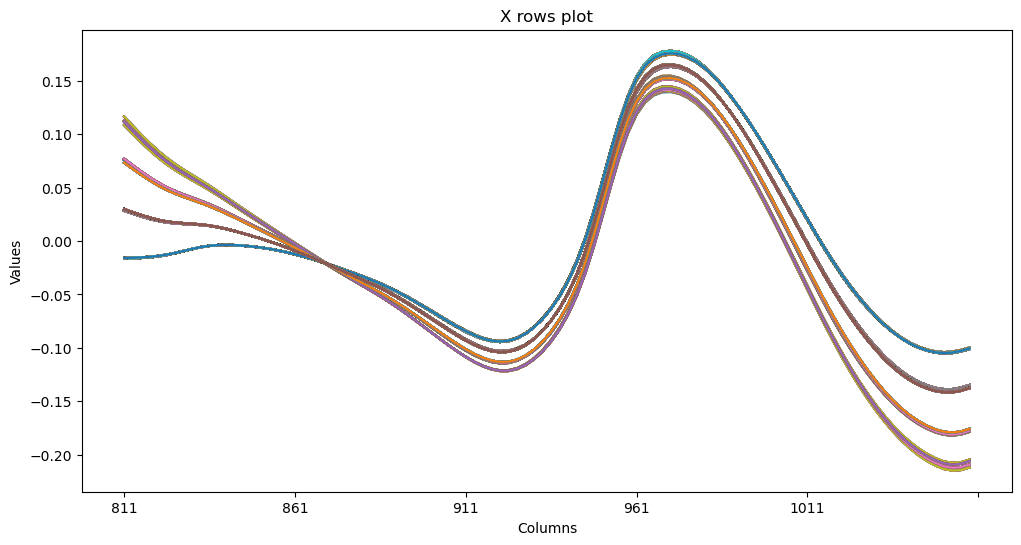

In [1279]:
X.T.plot(title='X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* y statistical information:

In [1280]:
y.describe()

,FluidT,SpectrT,ExpTime,H2O2,Cu,pH,A,H2O
count,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000
mean,23.161615,37.577937,0.530104,1.237964,617.754080,4.557163,3.399400,95.362636
std,0.640687,0.423663,0.762369,0.474822,536.875341,0.270592,0.279959,0.612651
min,21.630000,36.690000,0.043000,0.496900,0.000000,4.034000,2.885613,94.271214
25%,22.960000,37.310000,0.045000,0.897600,0.000000,4.508000,3.341072,94.715698
50%,23.190000,37.630000,0.362000,1.049100,696.597749,4.536000,3.482989,95.602400
75%,23.650000,37.810000,0.362000,1.689800,700.000000,4.563000,3.500000,95.602400
max,24.870000,38.440000,3.663000,2.114400,1990.530895,5.174000,3.889002,96.503100


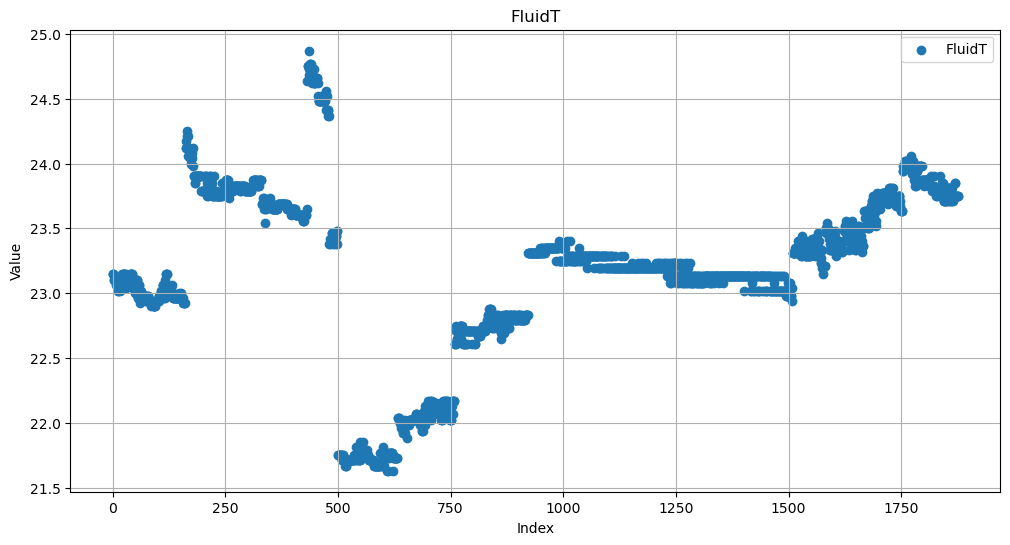

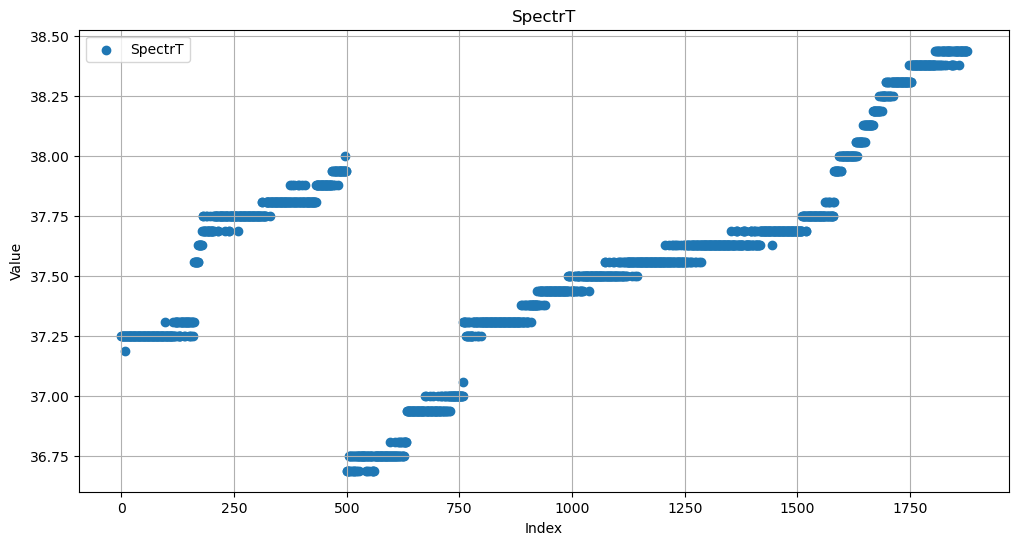

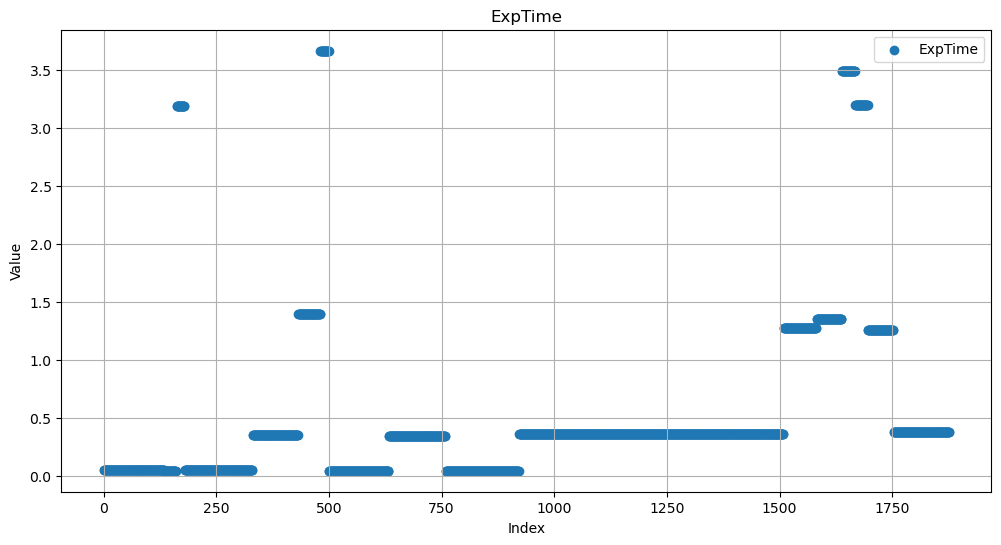

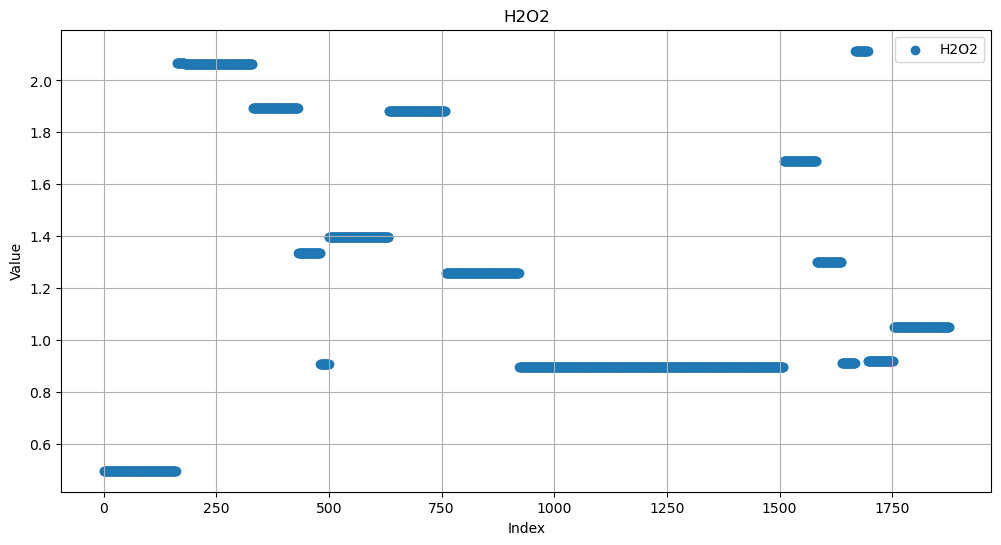

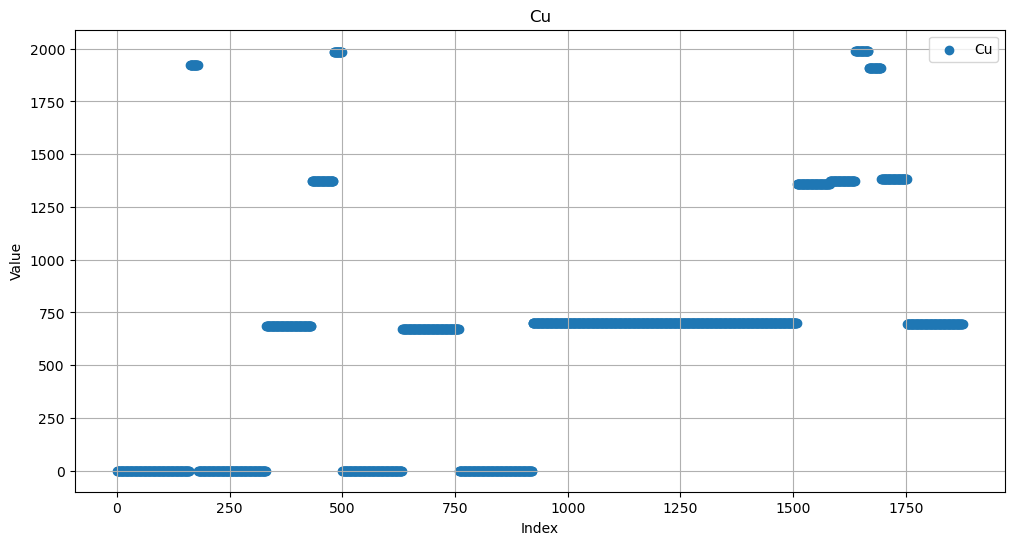

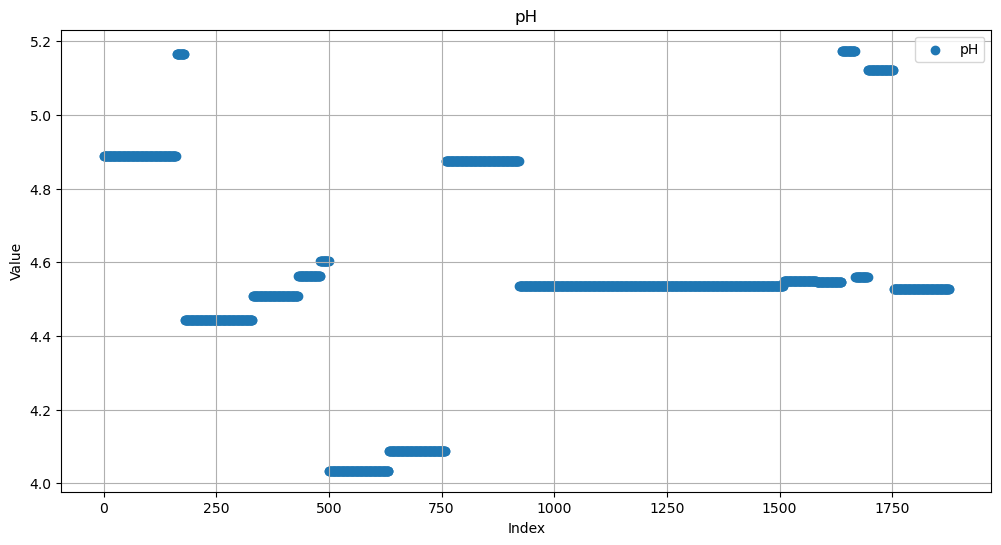

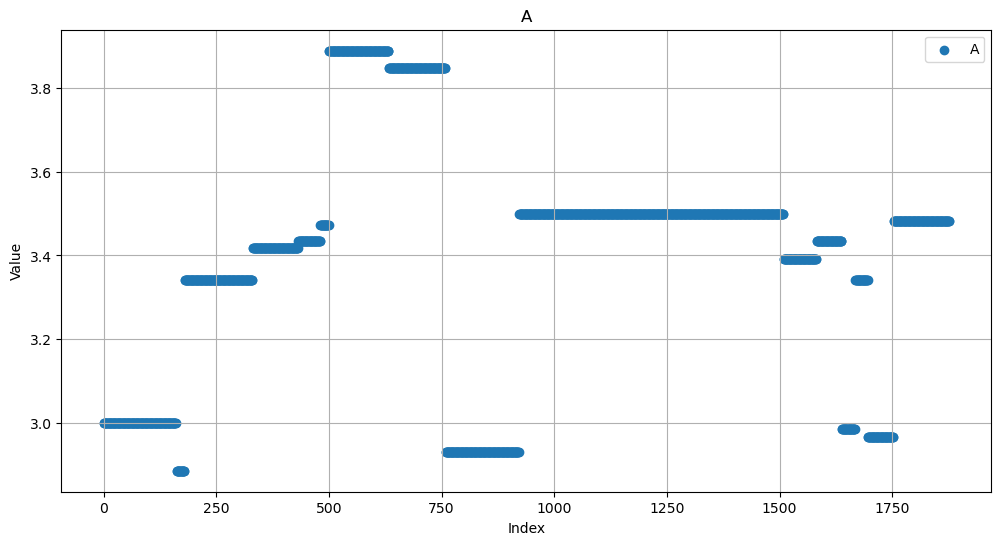

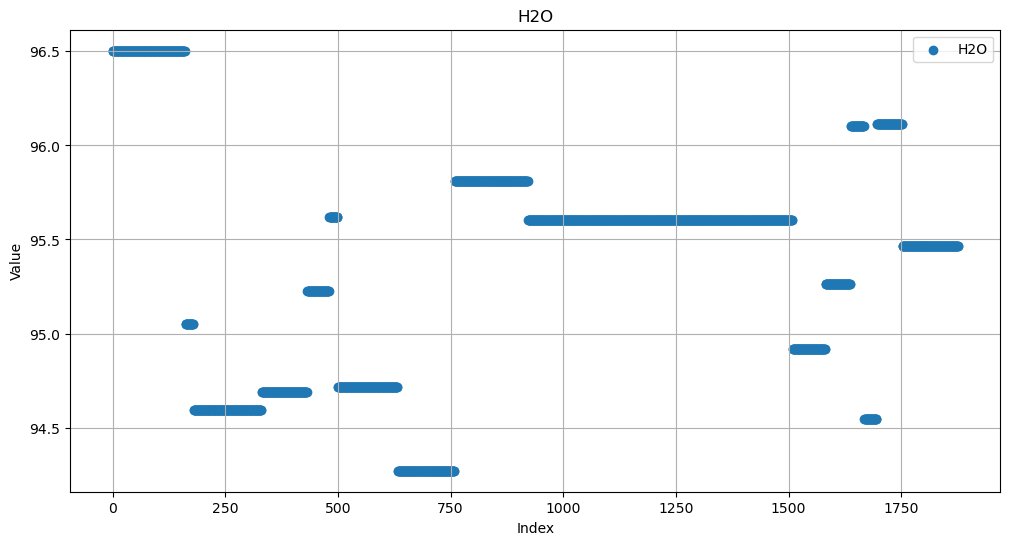

In [1281]:
# fig, axes = plt.subplots(nrows=4, ncols=2)
for i in y.columns:
    plt.scatter(y[i].index, y[i], label=i, marker='o')
    plt.title(i)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='best')
    
    plt.show()

## Removing distance-correlation anomalies

1. Evaluate similarities using correlation-distance

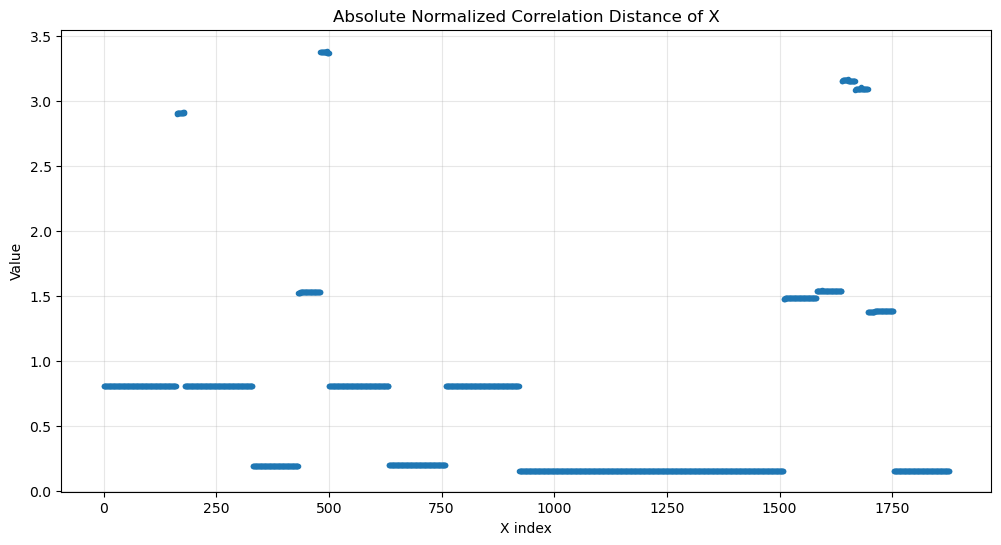

In [1282]:
dissimilarities = cdist(X, X, metric="correlation")
absolute_normalized_dissimilarities_vector = (np.abs((dissimilarities[1] - np.mean(dissimilarities[1])) / np.std(dissimilarities[1])))

plt.plot(X.index, absolute_normalized_dissimilarities_vector, '.')
plt.title('Absolute Normalized Correlation Distance of X')
plt.xlabel('X index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

2. Remove rows with values above threshold 

In [1283]:
corr_dist_threshold_high = 10
corr_dist_threshold_low = 0

high_lim_rows_to_remove = np.where((absolute_normalized_dissimilarities_vector > corr_dist_threshold_high))[0]
# low_lim_rows_to_remove = np.where((absolute_normalized_dissimilarities_vector < corr_dist_threshold_low))[0]

# rows_to_remove = list(high_lim_rows_to_remove) + list(low_lim_rows_to_remove)
rows_to_remove = list(high_lim_rows_to_remove)

print(f'Rows to remove from data: {rows_to_remove}')

Rows to remove from data: []


3. Remove rows from X and y

In [1284]:
X_filtered = X.drop(index=rows_to_remove)
y_filtered = y.drop(index=rows_to_remove)

In [1285]:
print(f'Number of rows remained: {X_filtered.shape[0]}')

Number of rows remained: 1876


4. Visual inspection

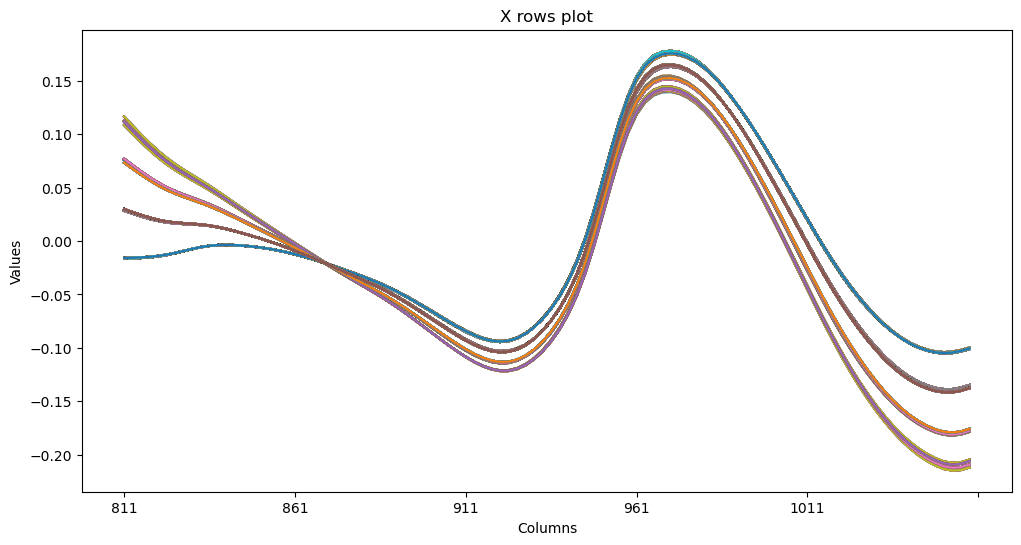

In [1286]:
X_filtered.T.plot(title='X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

## Removing meaurement anomalies in variables 

1. Removing meaurements which std is above threshold in each label  

In [1287]:
y_threshold = 3

df_temp = pd.concat([y_filtered, X_filtered], axis=1)
for col in df_temp[y_filtered.columns]:
    mean = df_temp[col].mean()
    std = df_temp[col].std()
    df_temp = df_temp[(df_temp[col] - mean).abs() <= (y_threshold * std)]


df_temp = df_temp.dropna()
df_temp = df_temp.reset_index(drop=True)

X_filtered = df_temp[selected_x_columns]
y_filtered = df_temp[selected_y_columns]

print(f'Number of rows remained: {X_filtered.shape[0]}')

Number of rows remained: 1781


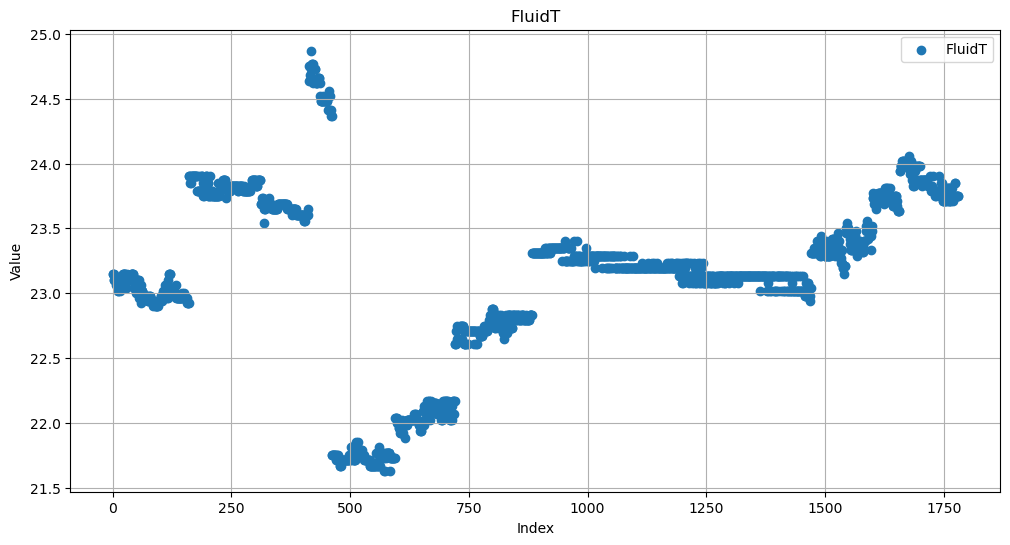

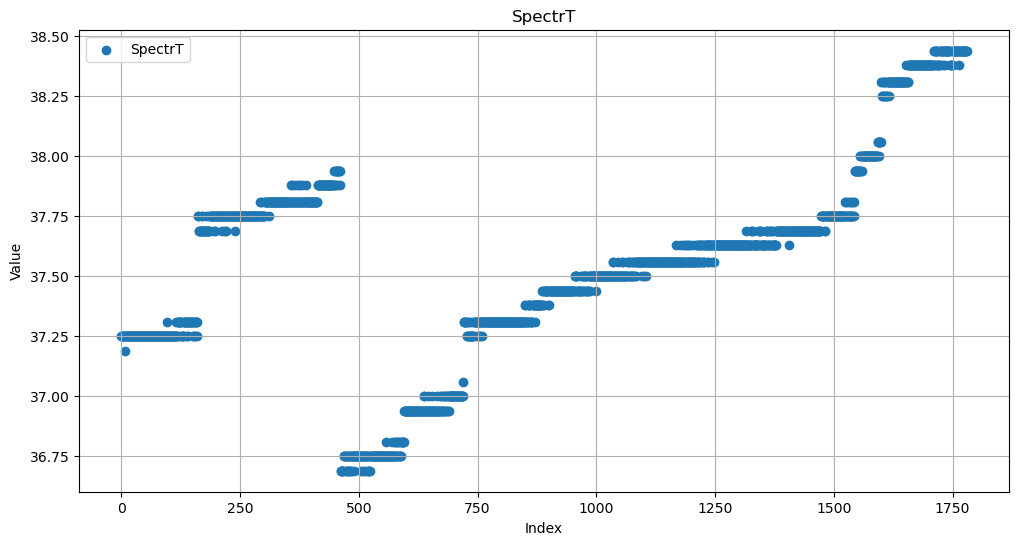

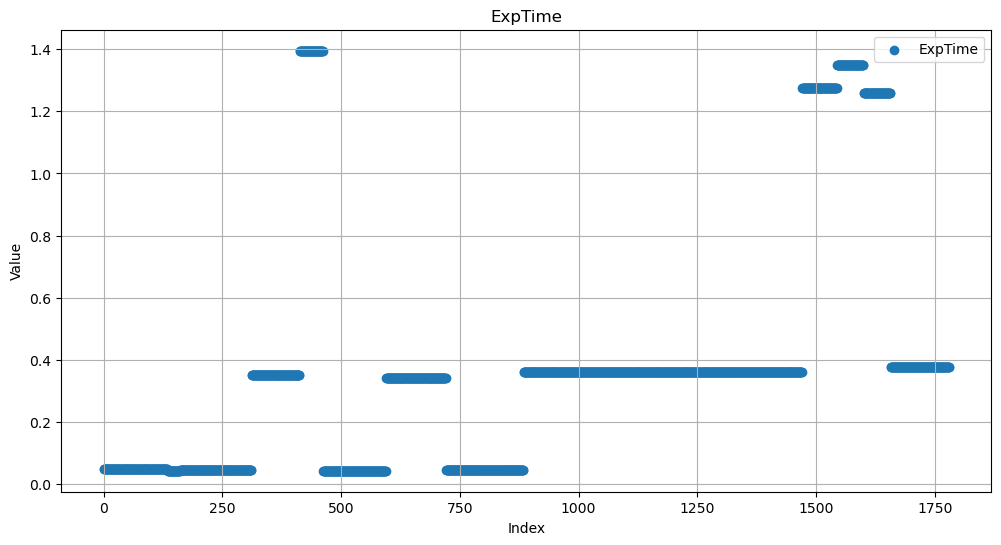

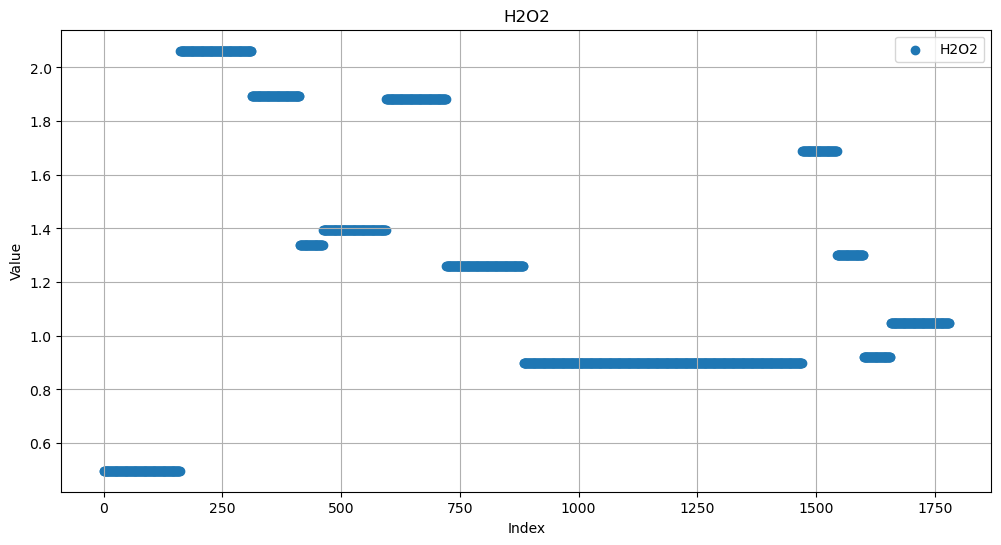

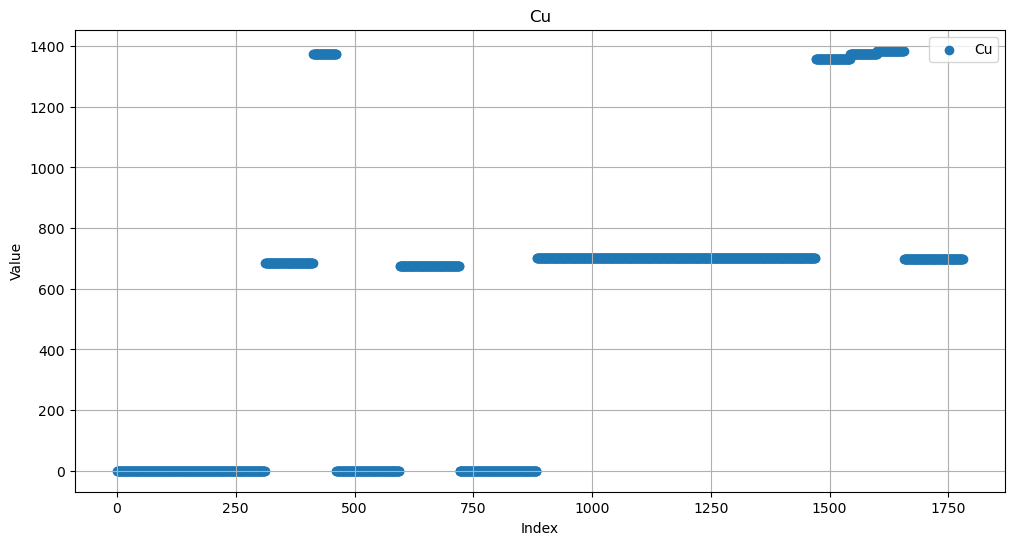

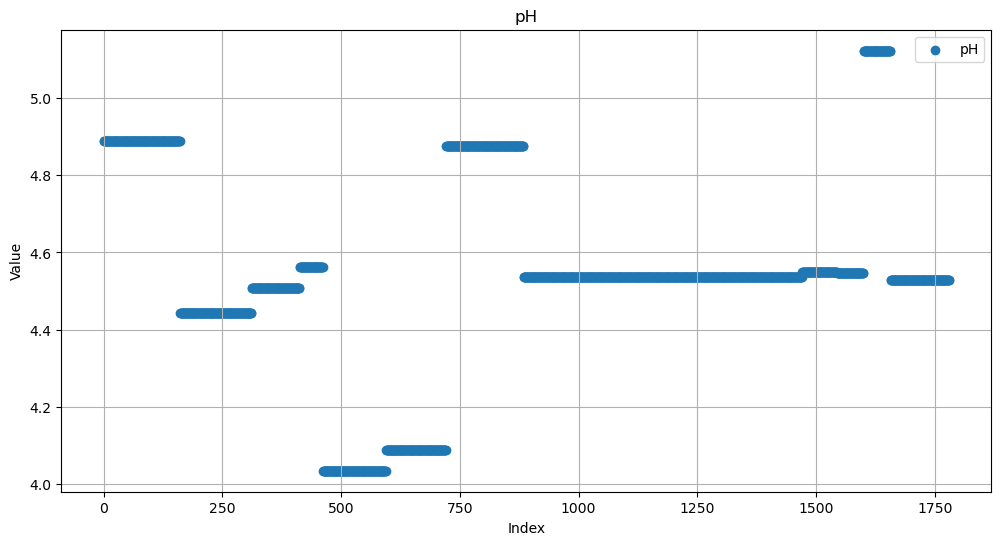

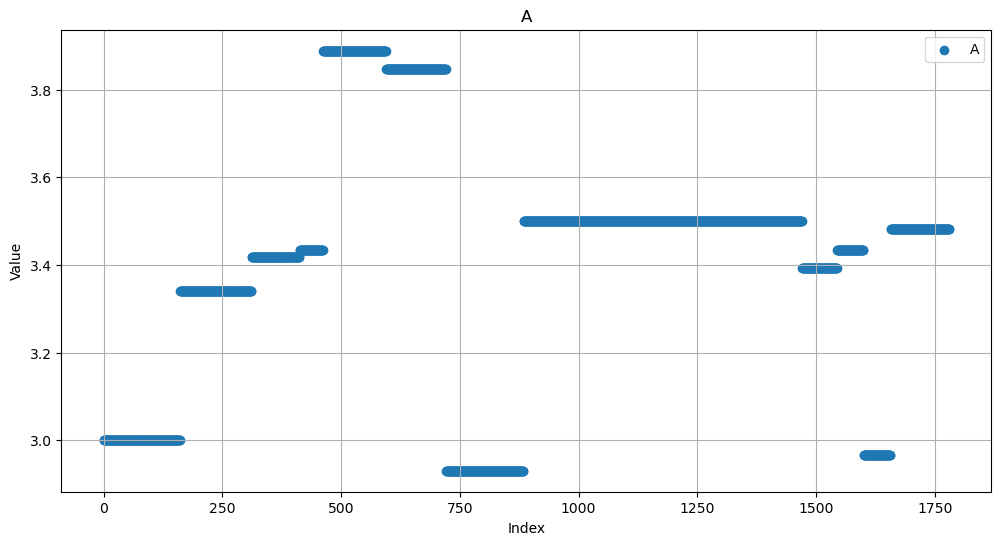

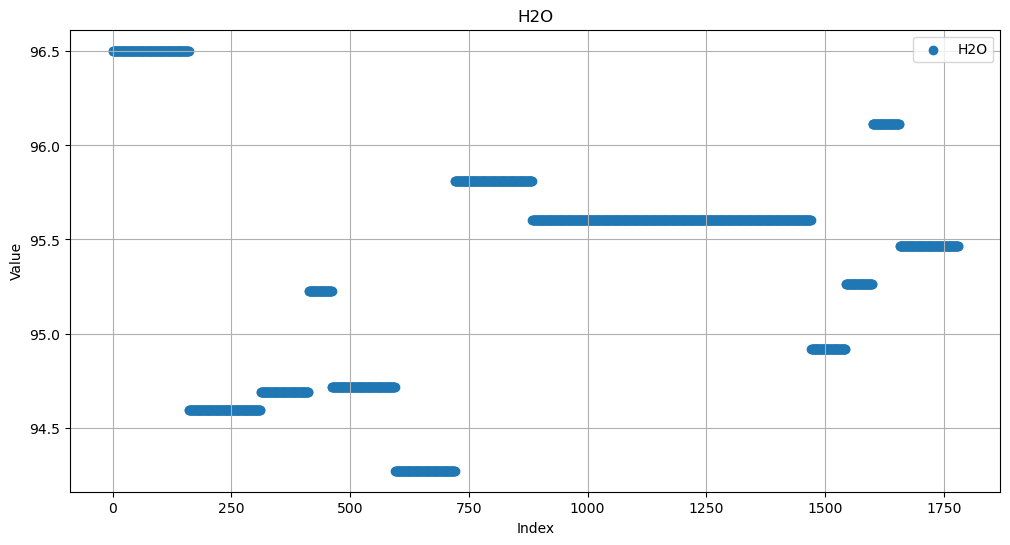

In [1288]:
for i in y_filtered.columns:
    plt.scatter(y_filtered[i].index, y_filtered[i], label=i, marker='o')
    plt.title(i)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='best')
    
    plt.show()

## Calulating 1st and 2nd orders derivatives 

In [1289]:
# Calculate derivatives
X1 = pd.DataFrame(savgol_filter(X_filtered, 11, polyorder = 2, deriv=1), columns=X.columns)
X2 = pd.DataFrame(savgol_filter(X_filtered, 11, polyorder = 2,deriv=2), columns=X.columns)

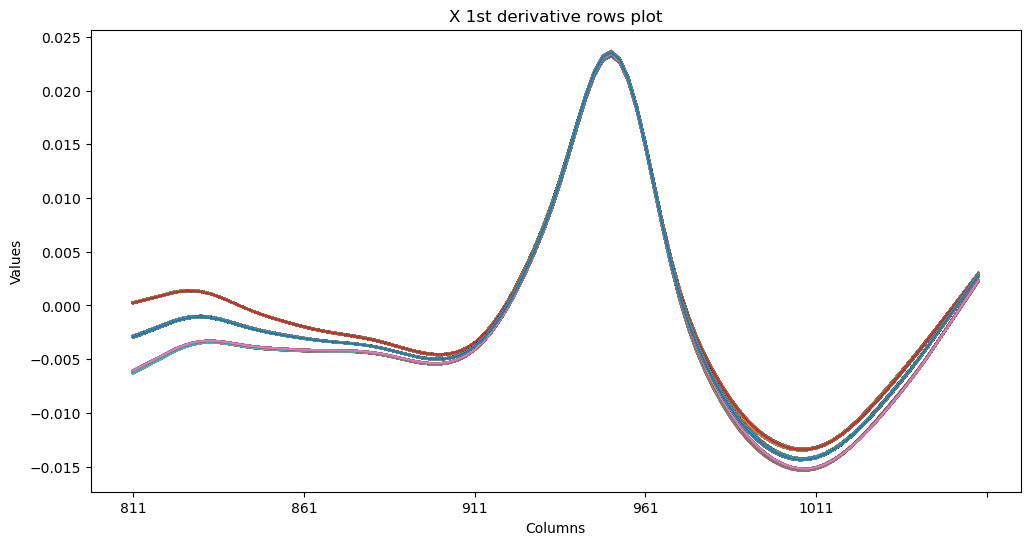

In [1290]:
X1.T.plot(title='X 1st derivative rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

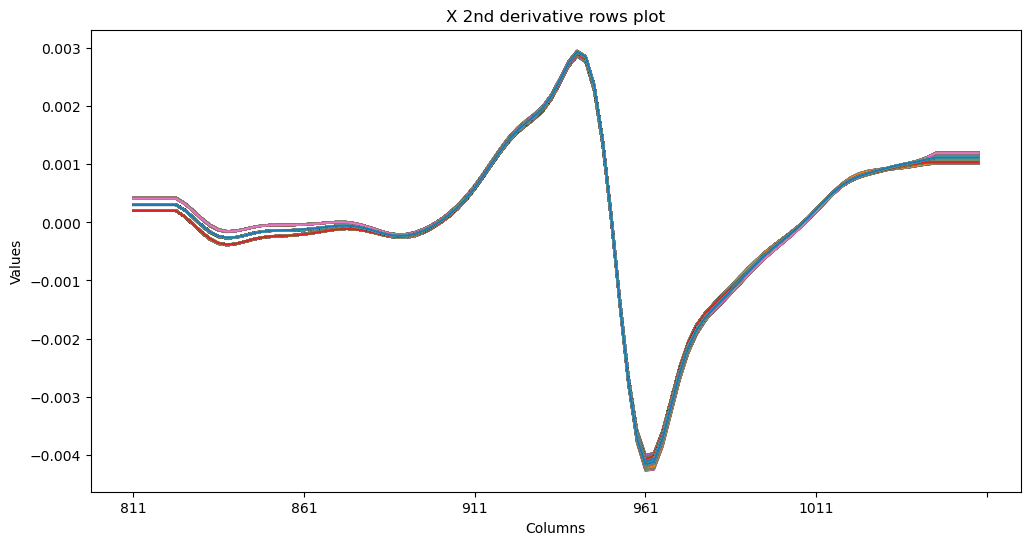

In [1291]:
X2.T.plot(title='X 2nd derivative rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

## Apply MSC

In [1292]:
pd.options.mode.chained_assignment = None

def apply_msc(_x):
    """
    Apply Multiplicative Scatter Correction (MSC) to NIR spectra.
    """
    temp_input = _x
    for i in range(temp_input.shape[0]):
        temp_input.iloc[i] -= temp_input.iloc[i].mean()

    ref = np.mean(temp_input, axis=0)

    # Define a new array and populate it with the corrected data
    data_msc = temp_input.copy()
    for i in range(temp_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, temp_input.iloc[i, :], 1, full=True)

        # Apply correction
        data_msc.iloc[i, :] = (temp_input.iloc[i, :] - fit[0][1]) / fit[0][0]

    Xmsc = data_msc.copy()

    return Xmsc

Xmsc = apply_msc(X_filtered)

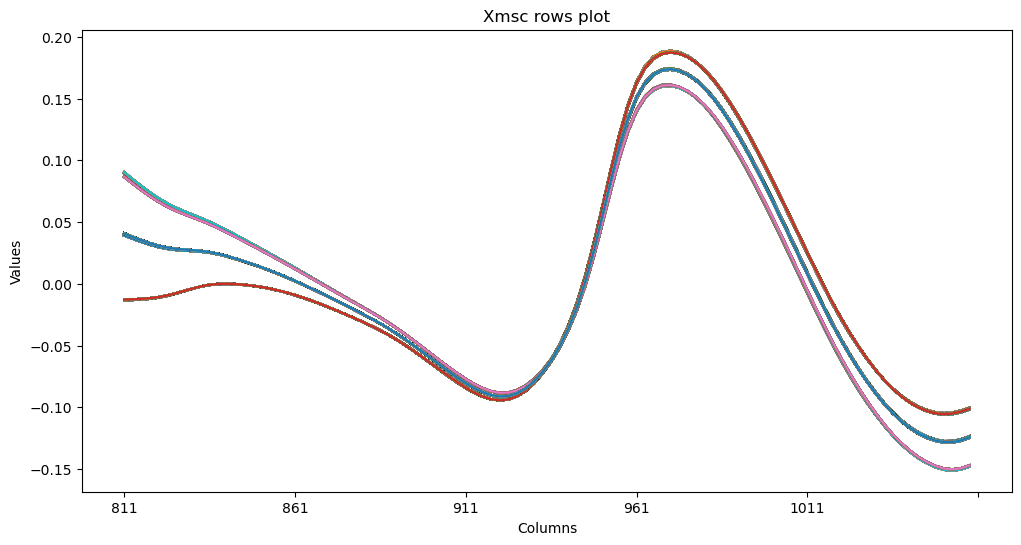

In [1293]:
Xmsc.T.plot(title='Xmsc rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

## Spliting the data into training and testing subsets

1. Define Group K-fold for the splitting train and test datasets

In [1294]:
total_number_of_groups = y_filtered[group_by].nunique()
test_groups_ratio = 0.2
total_test_groups = int(np.ceil((test_groups_ratio)*total_number_of_groups)) 

print(f'Total number of groups of label "{group_by}" = {total_number_of_groups}')
print(f'Total number of test groups = {total_test_groups}')

# Define GroupKFold
# gkf_test = KFold(n_splits=total_test_groups)
gkf_test = GroupShuffleSplit(n_splits=total_test_groups)
# gkf_test = GroupKFold(n_splits=total_test_groups)

Total number of groups of label "H2O" = 12
Total number of test groups = 3


2. split the data into train and test datasets

In [1295]:
chosen_X = X_filtered
chosen_y = y_filtered

for train_index, test_index in gkf_test.split(chosen_X, chosen_y, chosen_y[group_by]):
    x_train, x_test = chosen_X.iloc[train_index], chosen_X.iloc[test_index]
    y_train, y_test = chosen_y.iloc[train_index], chosen_y.iloc[test_index]

* summary

In [1296]:
print('Total data: ', x_train.shape[0] + x_test.shape[0])
print('Train data: ', x_train.shape[0])
print('Test data: ', x_test.shape[0])

Total data:  1781
Train data:  1500
Test data:  281


## Standardize the data using StandardScaler

* Create StandardScaler instance for train,cv and test data

In [1297]:
########################## -- uncomment to scale -- #############################################
# Initialize StandardScaler
# x_scaler = StandardScaler()
# y_scaler = StandardScaler()

# # Fit the scaler on the data and transform the data
# y_train_scaled = y_scaler.fit_transform(y_train)
# x_train_scaled = x_scaler.fit_transform(x_train.T)

# y_test_scaled = y_scaler.transform(y_test)
# x_test_scaled = x_scaler.transform(x_test.T)

# Convert the scaled data back to a DataFrame with original column names
# y_train_scaled = pd.DataFrame(y_train_scaled, columns=y.columns)
# x_train_scaled = pd.DataFrame(x_train_scaled.T, columns=X.columns)

# y_test_scaled = pd.DataFrame(y_test_scaled, columns=y.columns)
# x_test_scaled = pd.DataFrame(x_test_scaled.T, columns=X.columns)

##################################### -- comment to scale -- ##################################################

y_train_scaled = pd.DataFrame(y_train, columns=y.columns)
x_train_scaled = pd.DataFrame(x_train, columns=X.columns)

y_test_scaled = pd.DataFrame(y_test, columns=y.columns)
x_test_scaled = pd.DataFrame(x_test, columns=X.columns)

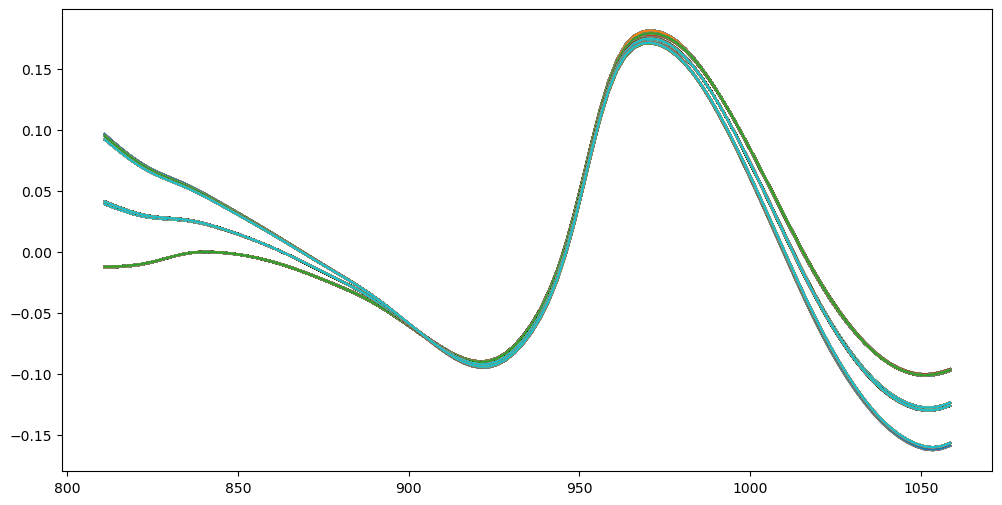

In [1298]:
plt.plot(x_train_scaled.T)
plt.show()

* X Train set

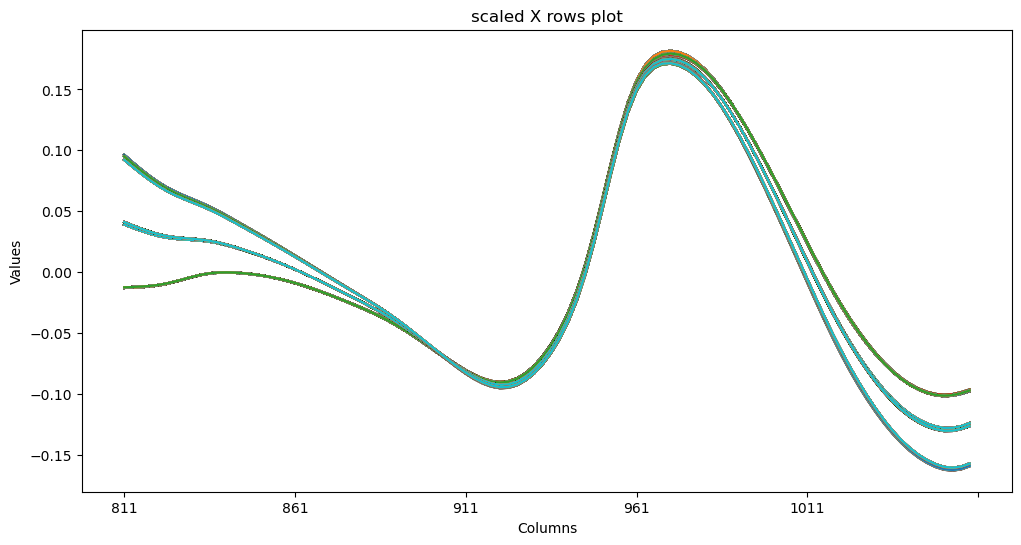

In [1299]:
x_train_scaled.T.plot(title='scaled X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* X test set

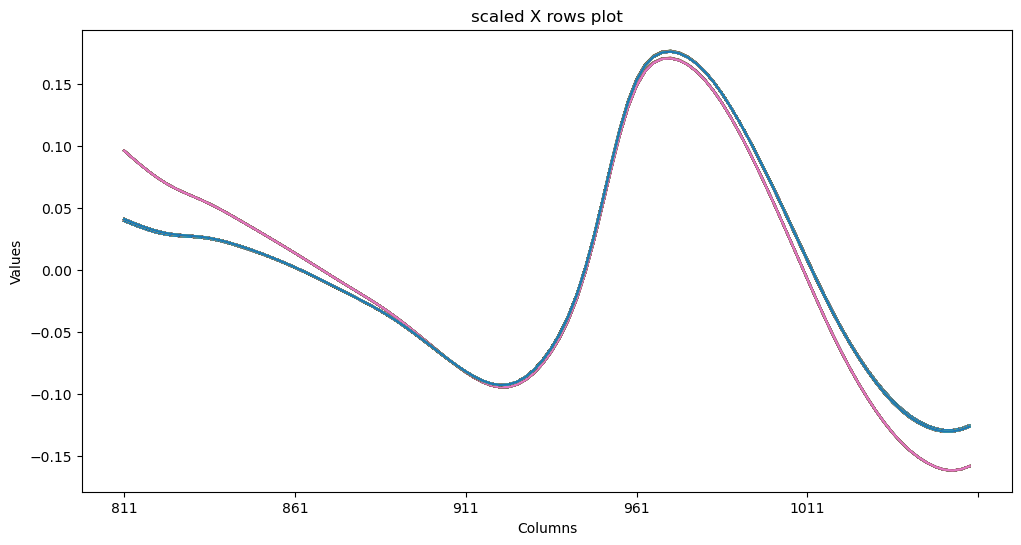

In [1300]:
x_test_scaled.T.plot(title='scaled X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* y train set

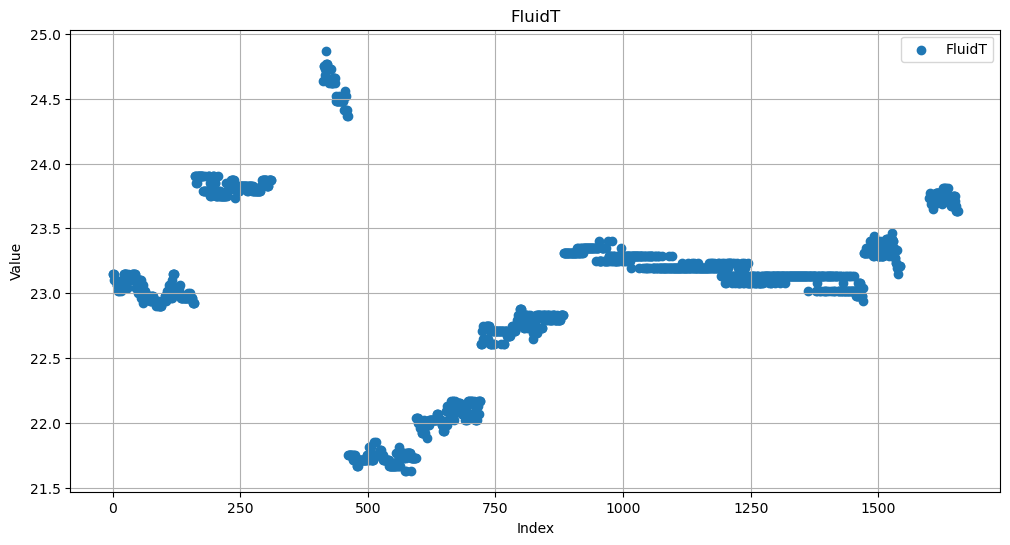

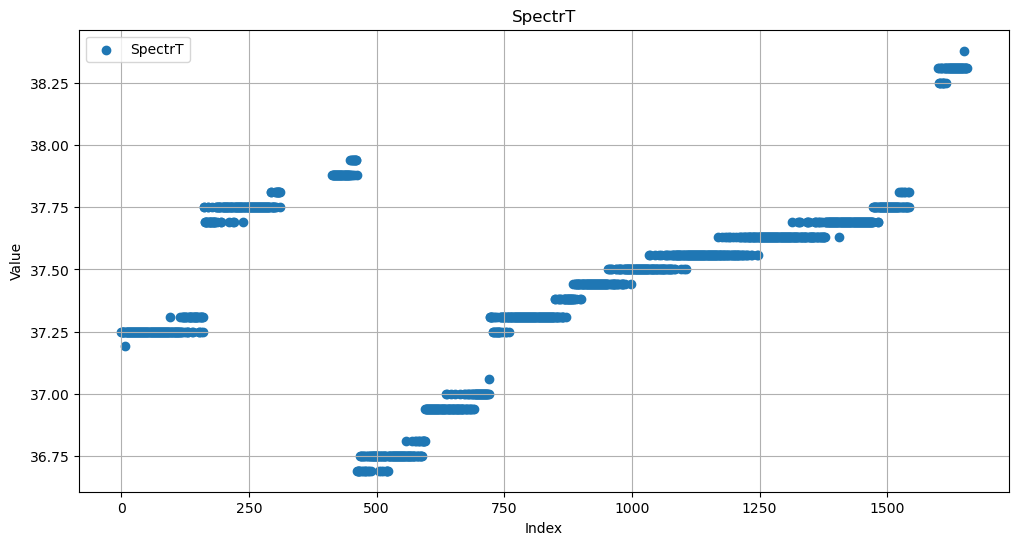

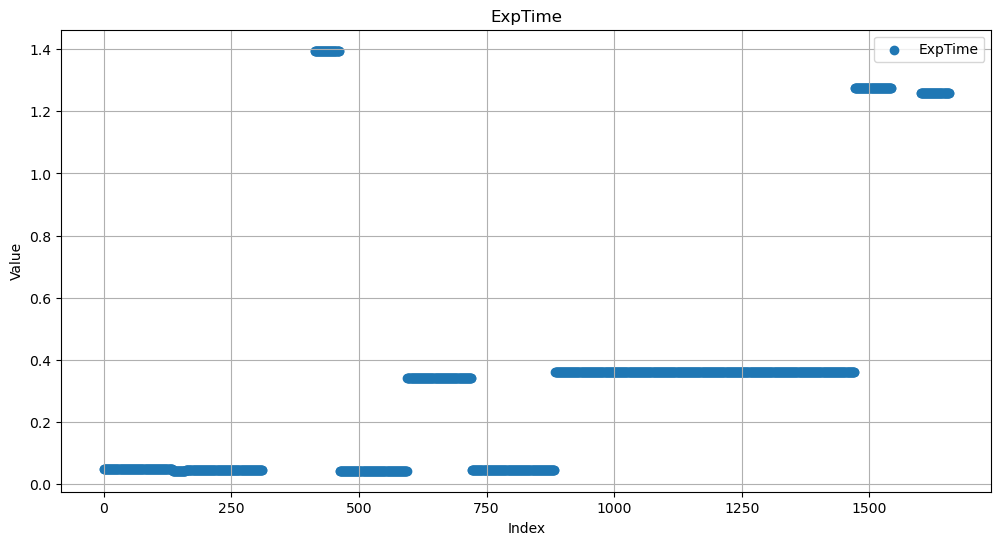

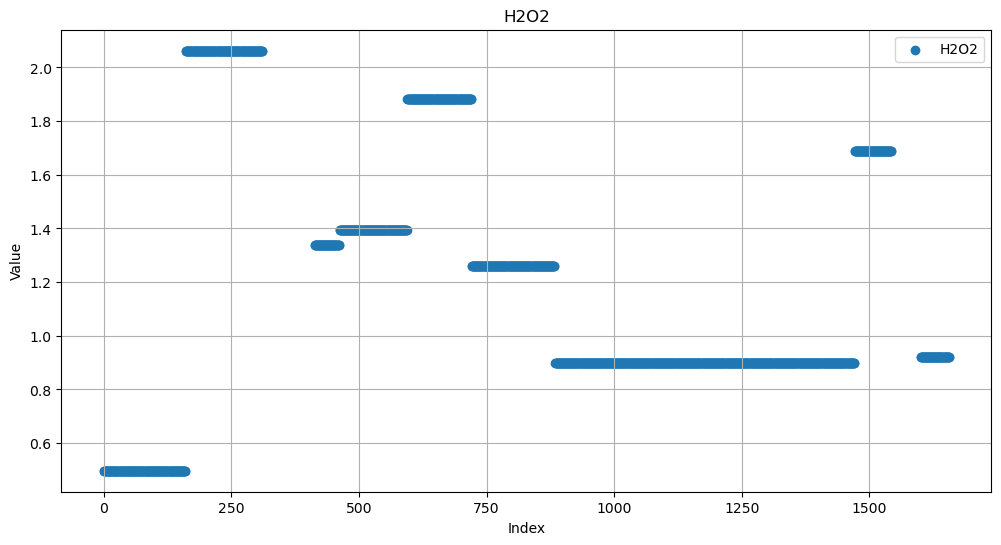

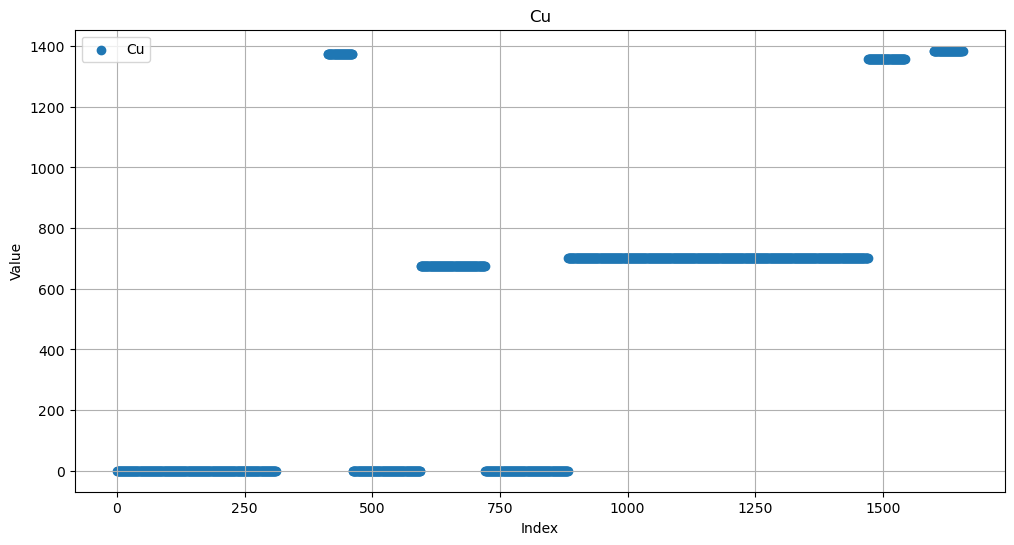

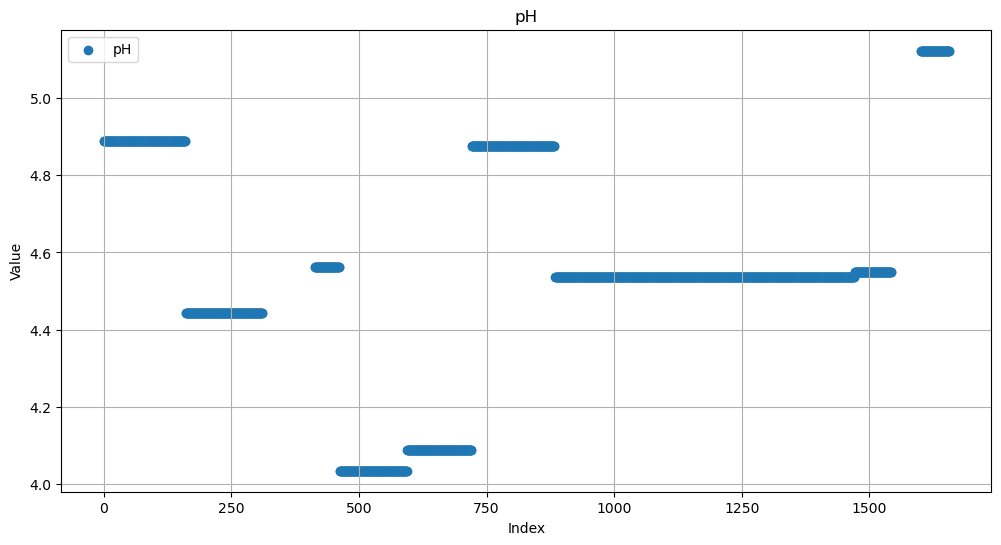

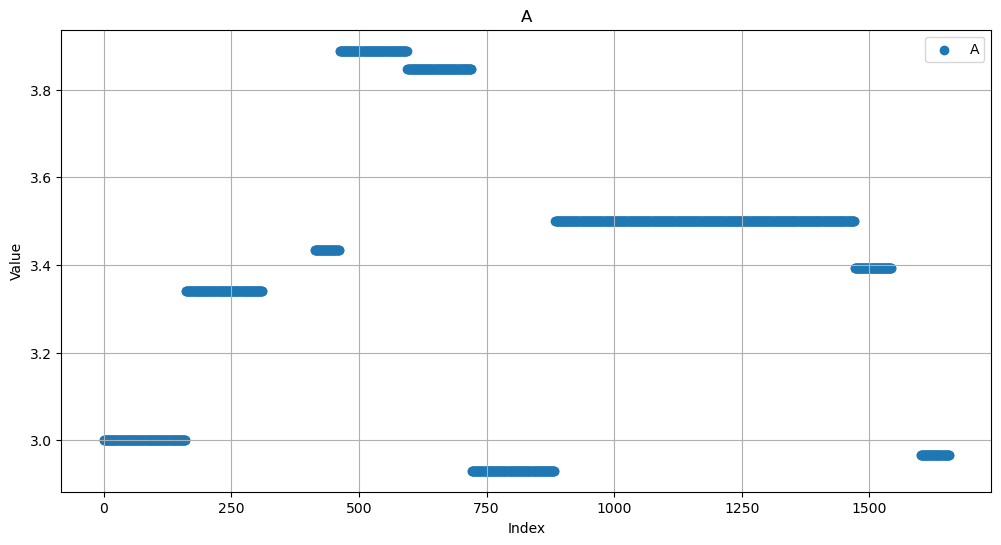

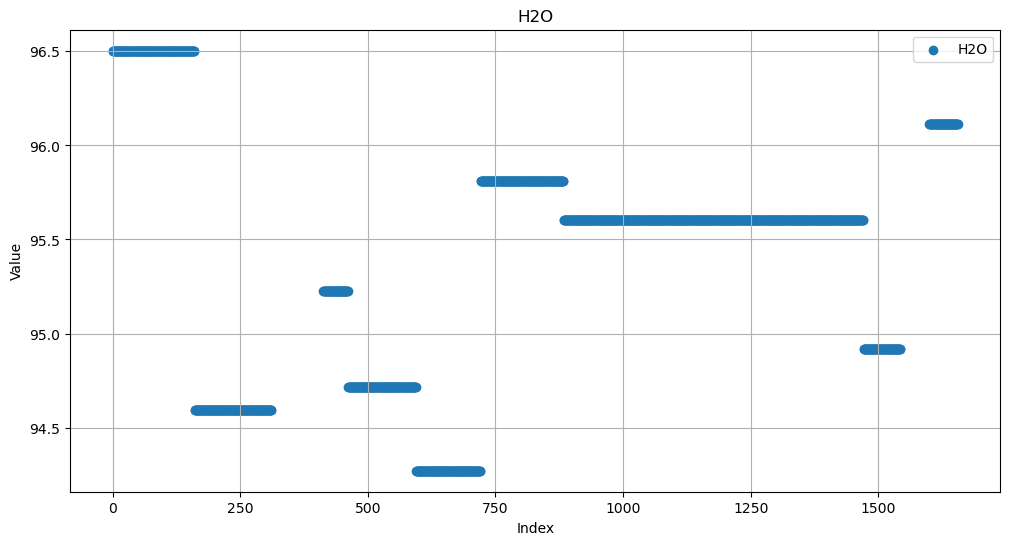

In [1301]:
for i in y_train_scaled.columns:
    plt.scatter(y_train_scaled[i].index, y_train_scaled[i], label=i, marker='o')
    plt.title(i)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='best')
    
    plt.show()

* y test set

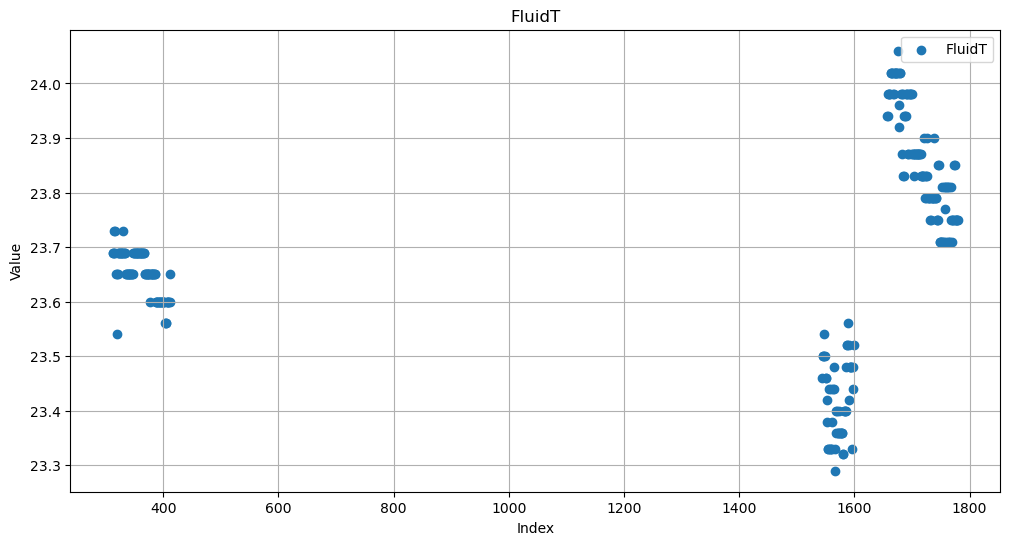

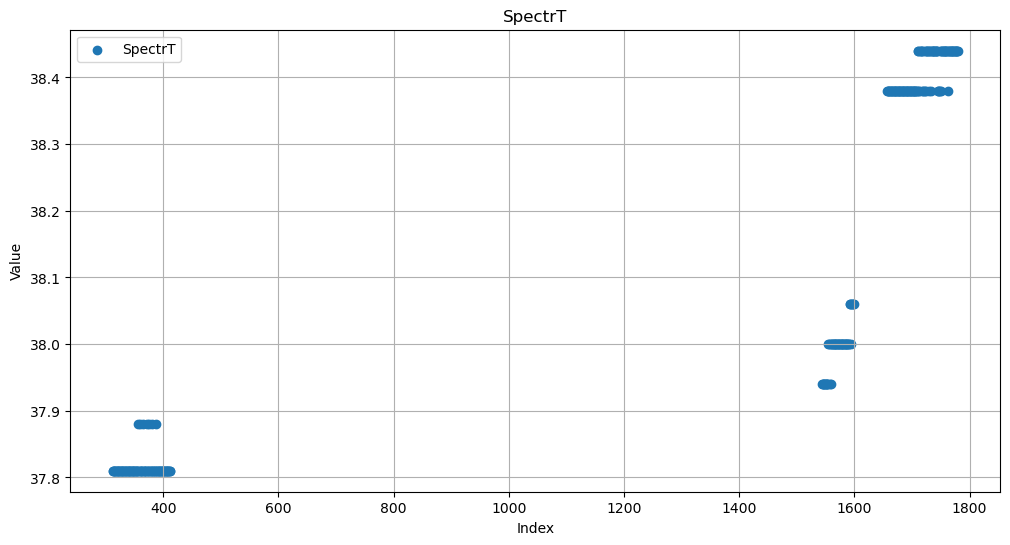

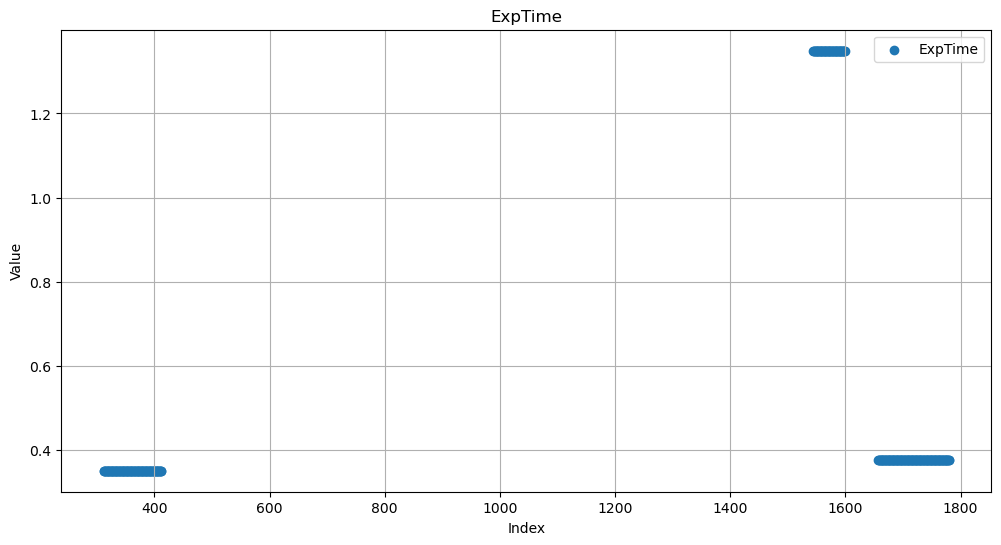

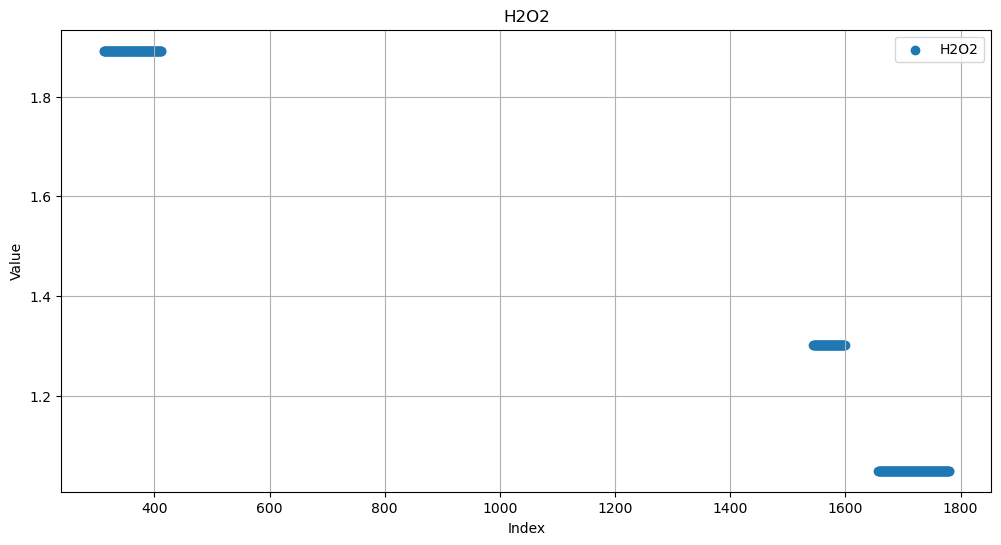

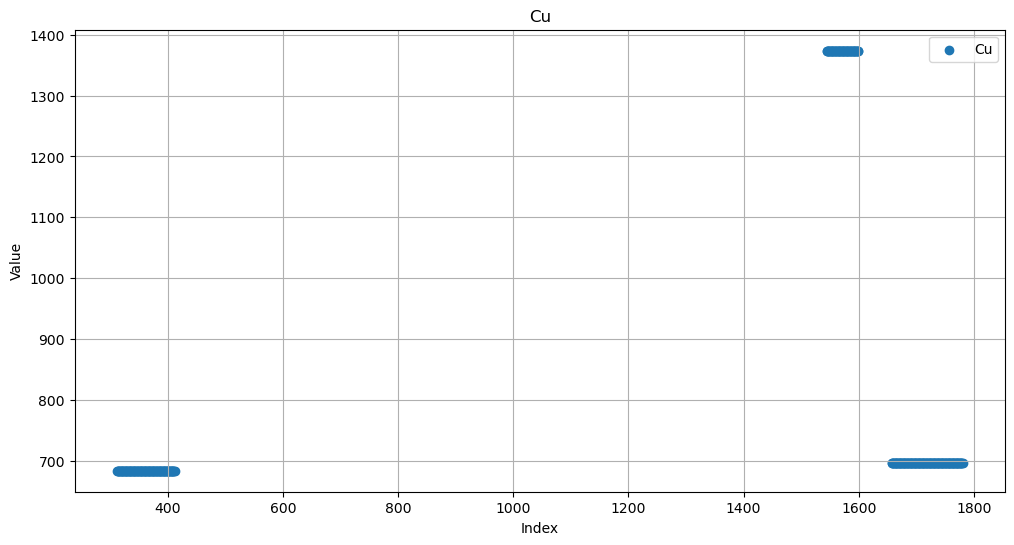

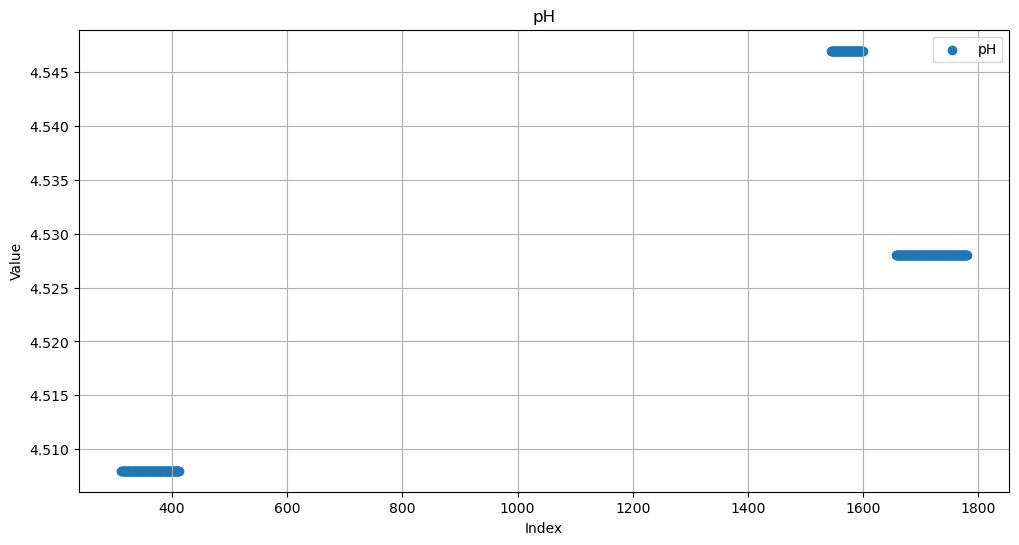

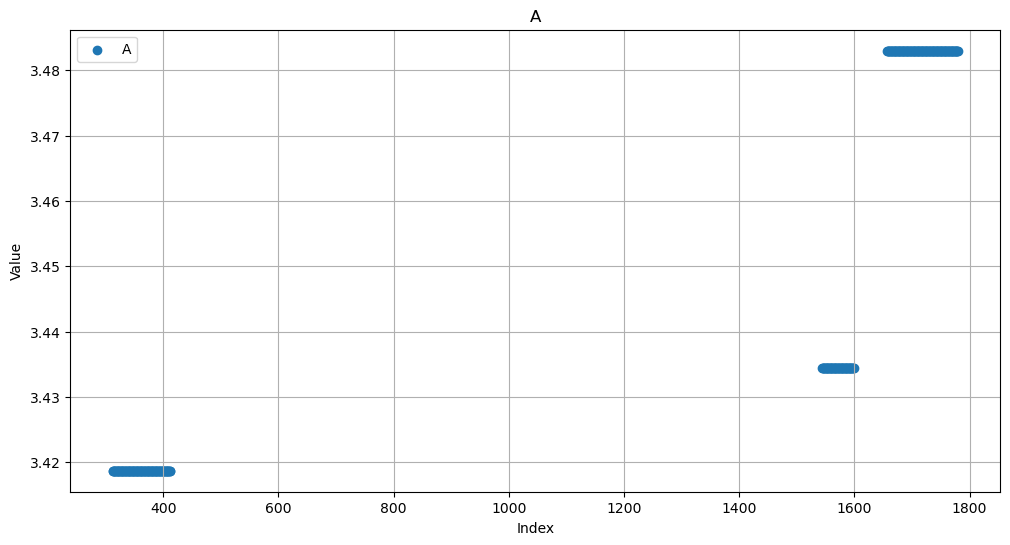

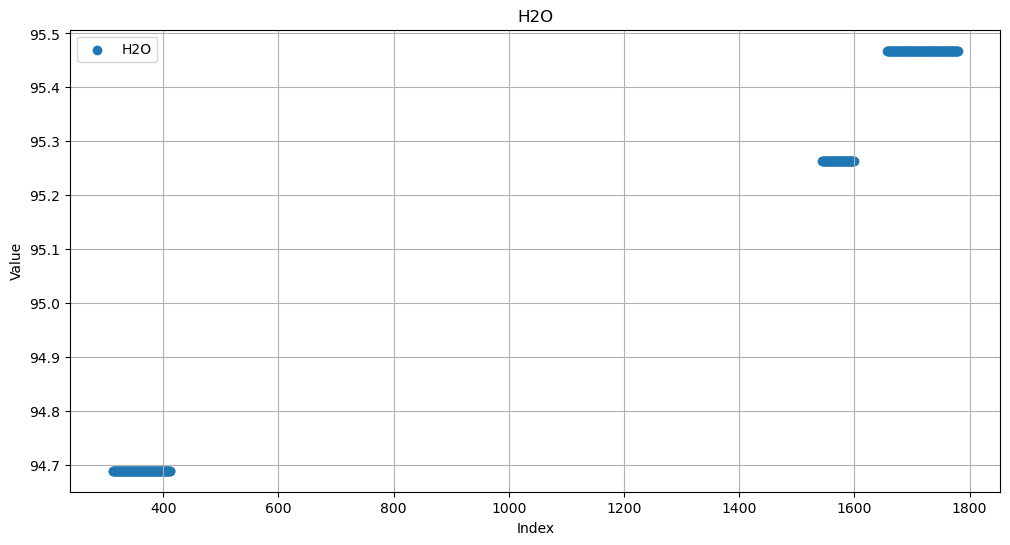

In [1302]:
for i in y_test_scaled.columns:
    plt.scatter(y_test_scaled[i].index, y_test_scaled[i], label=i, marker='o')
    plt.title(i)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='best')
    
    plt.show()

# PLS Regression

#### Select the labels to apply the model on

In [1303]:
print(y.columns.tolist())

['FluidT', 'SpectrT', 'ExpTime', 'H2O2', 'Cu', 'pH', 'A', 'H2O']


In [1304]:
selected_labels = ['H2O']
label_to_display = group_by
x_pls = x_train_scaled
y_pls = y_train_scaled[selected_labels]
y_pls_test = y_test_scaled[selected_labels] 

print(f'The features matrix to be modeled x_pls shape: {x_pls.shape}')
print(f'The labels matrix to be modeled y_pls shape: {y_pls.shape}')

The features matrix to be modeled x_pls shape: (1500, 100)
The labels matrix to be modeled y_pls shape: (1500, 1)


### Finding the best number of components for the model

1. Define the parameter space for the search

In [1305]:
parameters = {'n_components':np.arange(1,8,1)}

2. Define the grid-search estimator based on PLS regression

* define group k-fold

In [1306]:
# Define GroupKFold cross-validation
group_kfold = GroupKFold(n_splits=y_pls[label_to_display].nunique())
print(f'Group K-Fold: {group_kfold}')

Group K-Fold: GroupKFold(n_splits=9)


In [1307]:
pls = GridSearchCV(PLSRegression(scale=True), parameters, scoring = 'neg_mean_squared_error', verbose=1, cv=group_kfold)

3. fit the model to the training data

In [1308]:
pls.fit(x_pls, y_pls, groups=y_pls[label_to_display])

Fitting 9 folds for each of 7 candidates, totalling 63 fits


GridSearchCV(cv=GroupKFold(n_splits=9), estimator=PLSRegression(),
             param_grid={'n_components': array([1, 2, 3, 4, 5, 6, 7])},
             scoring='neg_mean_squared_error', verbose=1)

4. The best estimator result

In [1309]:
print(f'The number of components for the PLS model: \n{pls.best_estimator_}')

The number of components for the PLS model: 
PLSRegression(n_components=7)


4. Self prediction results

In [1310]:
y_pred_train = pls.predict(x_pls)
y_pred_train = pd.DataFrame(y_pred_train, columns=selected_labels)

print(f'The self prediction matrix y_pred_train shape: {y_pred_train.shape}')

The self prediction matrix y_pred_train shape: (1500, 1)


In [1311]:
rmse_train, r2_train = np.sqrt(mean_squared_error(y_pls[label_to_display], y_pred_train[label_to_display])), r2_score(y_pls[label_to_display], y_pred_train[label_to_display])

### Applying cross validation for the model using the best estimator

1. Apply the best estimator to calculate a cross-validation predicted variable

In [1312]:
y_pred_cv = cross_val_predict(pls.best_estimator_, x_pls, y_pls, groups=y_pls[label_to_display], cv=group_kfold)
y_pred_cv = pd.DataFrame(y_pred_cv, columns=selected_labels)

print(f'The cross-validation prediction matrix y_cv shape: {y_pred_cv.shape}')

The cross-validation prediction matrix y_cv shape: (1500, 1)


2. Calculate figures of merit

In [1313]:
rmse_cv, r2_cv = np.sqrt(mean_squared_error(y_pls[label_to_display], y_pred_cv[label_to_display])), r2_score(y_pls[label_to_display], y_pred_cv[label_to_display])

### Validating the model using Test dataset

In [1314]:
y_pred_test = pls.predict(x_test_scaled)
y_pred_test = pd.DataFrame(y_pred_test, columns=selected_labels)

In [1315]:
rmse_test, r2_test = np.sqrt(mean_squared_error(y_pls_test[label_to_display], y_pred_test[label_to_display])), r2_score(y_pls_test[label_to_display], y_pred_test[label_to_display])

3. Plot the results

In [1316]:
def regression_plot(y_train, y_pred_train, y_pred_cv, y_test, y_pred_test, rmse_train, r2_train, \
                    rmse_cv, r2_cv, rmse_test, r2_test, title = None, variable = None):
 
    # Regression plot
 
    z_train = np.polyfit(y_train, y_pred_train, 1)
    z_cv = np.polyfit(y_train, y_pred_cv, 1)
    z_test = np.polyfit(y_test, y_pred_test, 1)

    
    with plt.style.context(('seaborn-v0_8-white')):
        fig, ax = plt.subplots(figsize=(16, 9))
        
        # Creating the legend table
        legend_table = ax.table(
            cellText=[[f'Train', f'{rmse_train:.6f}', f'{r2_train:.6f}', f'{z_train[0]:.6f}'],
                      [f'CV', f'{rmse_cv:.6f}', f'{r2_cv:.6f}', f'{z_cv[0]:.6f}'],
                      [f'Test', f'{rmse_test:.6f}', f'{r2_test:.6f}', f'{z_test[0]:.6f}']],
            colLabels=['', 'RMSE', 'R-Square', 'Slope'],
            loc='upper left',
            cellLoc='center',
            cellColours=[['w', 'b', 'b', 'b'], ['w', 'r', 'r', 'r'], ['w', 'g', 'g', 'g']])

        # Styling the legend table
        legend_table.auto_set_font_size(False)
        legend_table.set_fontsize(10)
        legend_table.scale(0.4, 1.2) 
    
        ax.scatter(y_train, y_pred_train, c='blue', edgecolors='k', alpha=0.75, label='Train')
        ax.scatter(y_train, y_pred_cv, c='red', edgecolors='k', alpha=0.5, label='Cross Validation')
        ax.scatter(y_test, y_pred_test, c='green', edgecolors='k', alpha=0.3, label='Test')
        ax.plot(y_train, z_train[1]+z_train[0]*y_train, c='blue', linewidth=1, label='Model line')
        ax.plot(y_train, z_cv[1]+z_cv[0]*y_train, c='red', linewidth=1, label='CV line')
        ax.plot(y_test, z_test[1]+z_test[0]*y_test, c='green', linewidth=1, label='Test line')
        ax.plot(y_train, y_train, color='k', linewidth=1, label='Ideal line')
 
        if title is not None:
            plt.title(title, fontsize=12)
        if variable is not None:
            plt.xlabel('Measured ' + variable, fontsize=12)
            plt.ylabel('Predicted ' + variable, fontsize=12)
 
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.2)
        plt.legend(loc='lower right')
    plt.show()

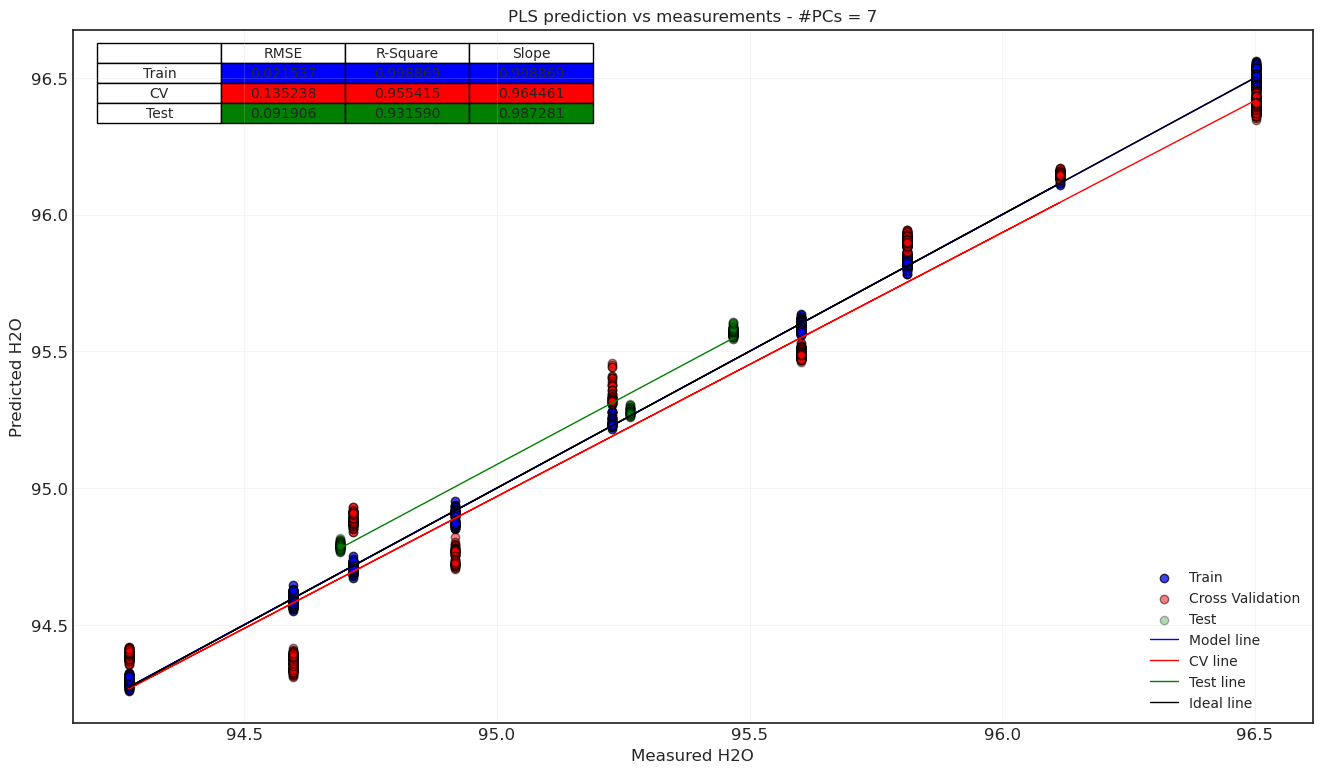

In [1317]:
regression_plot(y_pls[label_to_display], y_pred_train[label_to_display],
                y_pred_cv[label_to_display], y_pls_test[label_to_display],
                y_pred_test[label_to_display], rmse_train, r2_train,
                rmse_cv, r2_cv, rmse_test, r2_test,
                title = f"PLS prediction vs measurements - #PCs = {pls.best_estimator_.n_components}",
                variable = label_to_display)

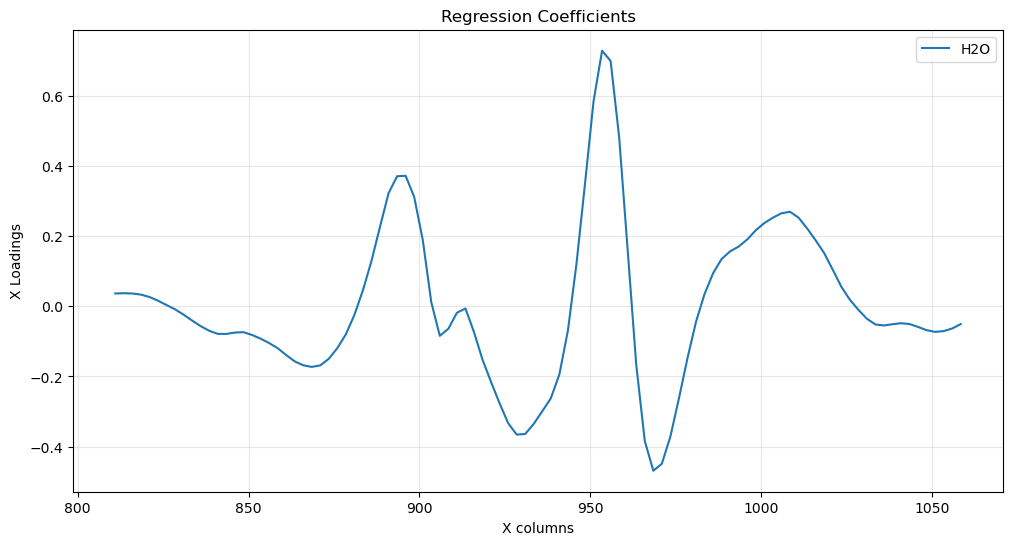

In [1318]:
for i, _label in enumerate(selected_labels):
    if label_to_display == _label:
        break
plt.plot(X.columns, pls.best_estimator_.coef_[i], label=label_to_display)
plt.xlabel('X columns')
plt.ylabel('X Loadings')
plt.title('Regression Coefficients')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

## Model optimization 

### Outlier detection and removal

1. Outlier sorting using Q residuals and Hotelling's Tsquared

In [1319]:
ncomp = pls.best_estimator_.n_components

# Get X scores
T = pls.best_estimator_.x_scores_

# Get X loadings
P = pls.best_estimator_.x_loadings_
 
# Calculate error array
Err = x_pls - np.dot(T, P.T)
 
# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)
 
# Calculate Hotelling's T-squared (note that data are normalised by default)
Tsq = np.sum((T/np.std(T, axis=0))**2, axis=1)

# set the confidence level
conf = 0.95
 

# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
            dfd=(x_pls.shape[0]-ncomp))*ncomp*(x_pls.shape[0]-1)/(x_pls.shape[0]-ncomp)
 
# Estimate the confidence level for the Q-residuals
i = np.max(Q)+1
while 1-np.sum(Q>i)/np.sum(Q>0)> conf:
    i -= 1
Q_conf = i

2. Visualize the outliers

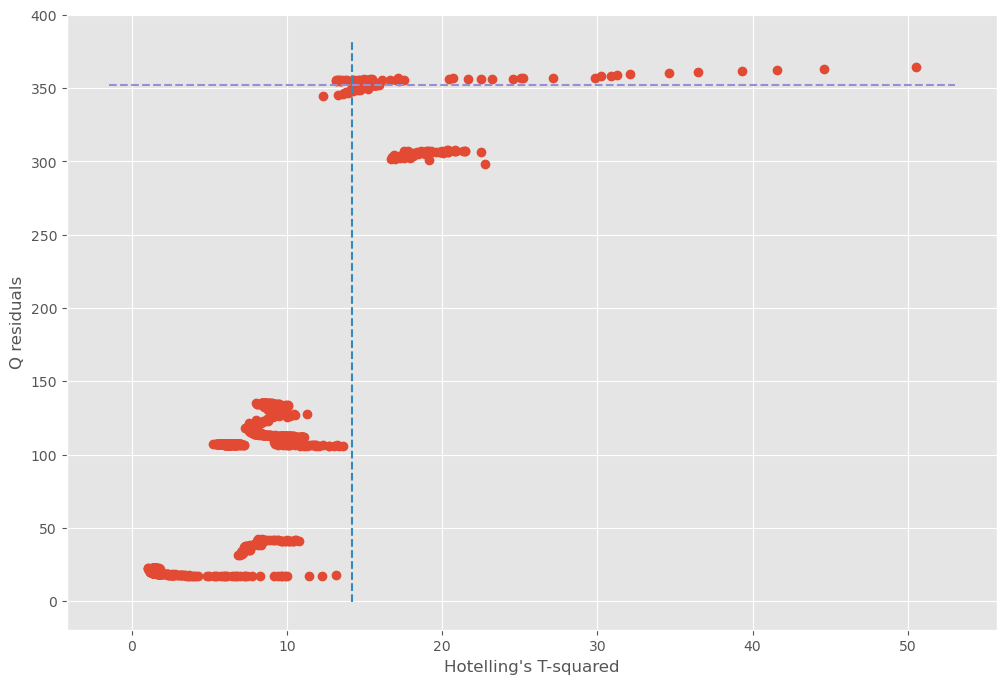

In [1320]:
ax = plt.figure(figsize=(12,8))
with plt.style.context(('ggplot')):
    plt.plot(Tsq, Q, 'o')
    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
 
plt.show()

3. Sort the data according to RMS distance from origin in descending order

In [1321]:
# Sort the RMS distance from the origin in descending order (largest first)
plscomp=pls.best_estimator_.n_components
 
rms_dist = np.flip(np.argsort(np.sqrt(Q**2+Tsq**2)), axis=0)
 
# Sort calibration spectra according to descending RMS distance
Xc = x_pls.iloc[rms_dist, :]
Yc = y_pls.iloc[rms_dist, :]
 
# Discard one outlier at a time up to the value max_outliers
# and calculate the mse cross-validation of the PLS model
max_outliers = 200
 
# Define empty mse array
rmse = np.zeros(max_outliers)
 
for j in range(max_outliers):
 
    pls_temp = PLSRegression(n_components=plscomp, scale=True)
    pls_temp.fit(Xc.iloc[j:, :], Yc.iloc[j:, :])
    group_kfold = GroupKFold(n_splits=Yc[label_to_display].iloc[j:].nunique()-1)
    y_cv = cross_val_predict(pls_temp, Xc.iloc[j:, :], Yc.iloc[j:, :], groups=Yc[label_to_display].iloc[j:], cv=group_kfold) 
    y_cv = pd.DataFrame(y_cv, columns=Yc.columns)
 
    rmse[j] = np.sqrt(mean_squared_error(Yc[label_to_display].iloc[j:], y_cv[label_to_display]))
 
# Find the position of the minimum in the mse (excluding the zeros)
rmsemin = np.where(rmse==np.min(rmse[np.nonzero(rmse)]))[0][0]
rmsemin_index = np.argmin(rmse, axis=0)

In [1322]:
print(f'Removed {rmsemin_index} outliers')

Removed 178 outliers


4. Create features and labels matrices without the outliers

In [1323]:
x_outliers_removed = Xc.iloc[rmsemin_index:, :]
y_outliers_removed = Yc.iloc[rmsemin_index:, :]

print('Features matrix rows without outliers: ', x_outliers_removed.shape[0])
print('Labels matrix rows without outliers: ', y_outliers_removed.shape[0])

Features matrix rows without outliers:  1322
Labels matrix rows without outliers:  1322


5. Repeat the steps of PLS regression on the filtered data

In [1324]:
x_pls2_train = x_outliers_removed
y_pls2_train = y_outliers_removed

In [1325]:
print(f'The features matrix to be modeled x_pls2_train shape: {x_pls2_train.shape}')
print(f'The labels matrix to be modeled y_pls2_train shape: {y_pls2_train.shape}')

The features matrix to be modeled x_pls2_train shape: (1322, 100)
The labels matrix to be modeled y_pls2_train shape: (1322, 1)


### Finding the best number of components for the model

1. Define the parameter space for the search

In [1326]:
parameters2 = {'n_components':np.arange(1,8,1)}

2. Define the grid-search estimator based on PLS regression

* define group k-fold

In [1327]:
# Define GroupKFold cross-validation
group_kfold = GroupKFold(n_splits=y_pls2_train[label_to_display].nunique())
print(f'Group K-Fold: {group_kfold}')

Group K-Fold: GroupKFold(n_splits=7)


In [1328]:
pls2 = GridSearchCV(PLSRegression(scale=False), parameters2, scoring = 'neg_mean_squared_error', verbose=1, cv=group_kfold)

3. fit the model to the training data

In [1329]:
pls2.fit(x_pls2_train, y_pls2_train, groups=y_pls2_train[label_to_display])

Fitting 7 folds for each of 7 candidates, totalling 49 fits


GridSearchCV(cv=GroupKFold(n_splits=7), estimator=PLSRegression(scale=False),
             param_grid={'n_components': array([1, 2, 3, 4, 5, 6, 7])},
             scoring='neg_mean_squared_error', verbose=1)

4. The best estimator result

In [1330]:
print(f'The number of components for the PLS model: \n{pls2.best_estimator_}')

The number of components for the PLS model: 
PLSRegression(n_components=7, scale=False)


4. Self prediction results

In [1331]:
y_pred_train2 = pls2.predict(x_pls2_train)
y_pred_train2 = pd.DataFrame(y_pred_train2, columns=selected_labels)

print(f'The self prediction matrix y_pred_train shape: {y_pred_train2.shape}')

The self prediction matrix y_pred_train shape: (1322, 1)


In [1332]:
rmse_train2, r2_train2 = np.sqrt(mean_squared_error(y_pls2_train[label_to_display], y_pred_train2[label_to_display])), \
r2_score(y_pls2_train[label_to_display], y_pred_train2[label_to_display])

### Applying cross validation for the model using the best estimator

1. Apply the best estimator to calculate a cross-validation predicted variable

In [1333]:
y_pred_cv2 = cross_val_predict(pls2.best_estimator_, x_pls2_train, y_pls2_train, groups=y_pls2_train[label_to_display], cv=group_kfold)
y_pred_cv2 = pd.DataFrame(y_pred_cv2, columns=selected_labels)

print(f'The cross-validation prediction matrix y_cv shape: {y_pred_cv2.shape}')

The cross-validation prediction matrix y_cv shape: (1322, 1)


2. Calculate figures of merit

In [1334]:
rmse_cv2, r2_cv2 = np.sqrt(mean_squared_error(y_pls2_train[label_to_display], y_pred_cv2[label_to_display])), \
r2_score(y_pls2_train[label_to_display], y_pred_cv2[label_to_display])

### Validating the model using Test dataset

In [1335]:
y_pred_test2 = pls2.predict(x_test_scaled)
y_pred_test2 = pd.DataFrame(y_pred_test2, columns=selected_labels)

In [1336]:
rmse_test2, r2_test2 = np.sqrt(mean_squared_error(y_pls_test[label_to_display], y_pred_test2[label_to_display])), \
r2_score(y_pls_test[label_to_display], y_pred_test2[label_to_display])

3. Plot the results

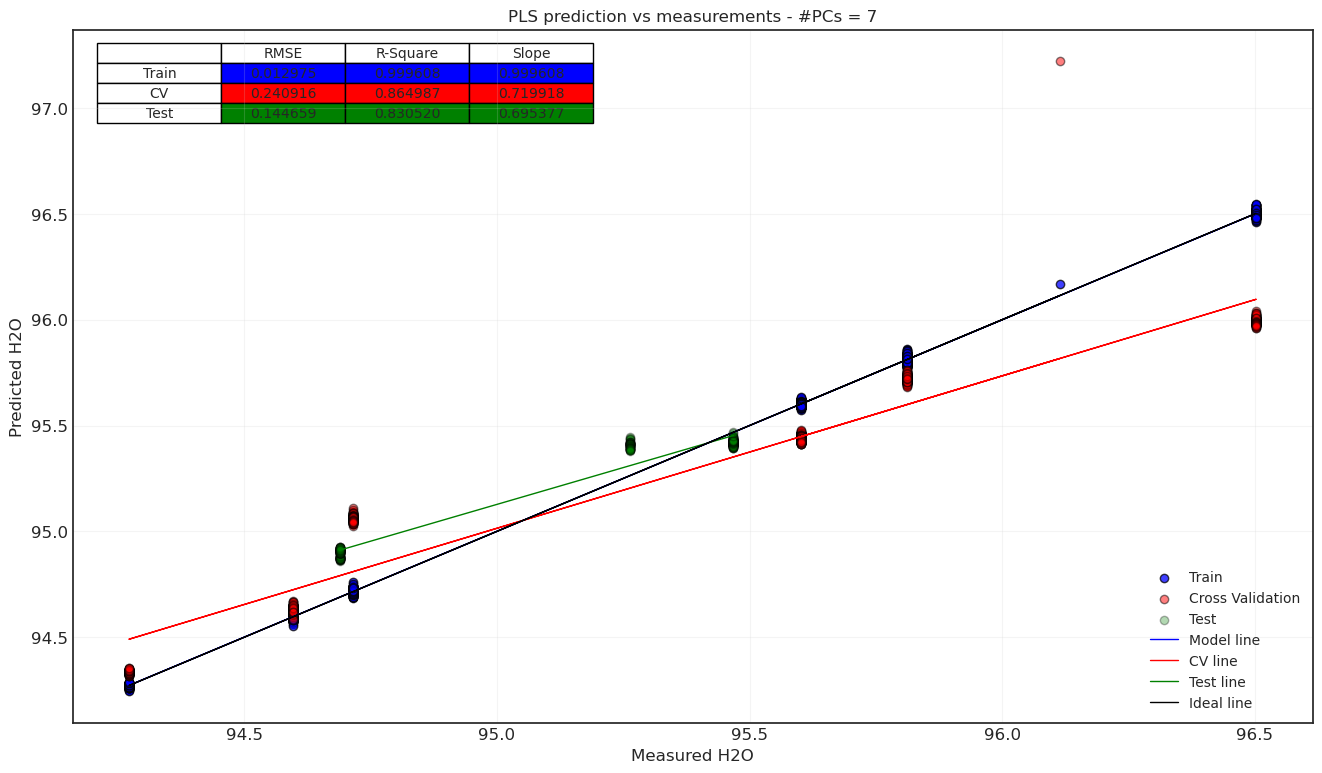

In [1337]:
regression_plot(y_pls2_train[label_to_display], y_pred_train2[label_to_display],
                y_pred_cv2[label_to_display], y_pls_test[label_to_display],
                y_pred_test2[label_to_display], rmse_train2, r2_train2,
                rmse_cv2, r2_cv2, rmse_test2, r2_test2,
                title = f"PLS prediction vs measurements - #PCs = {pls2.best_estimator_.n_components}",
                variable = label_to_display)

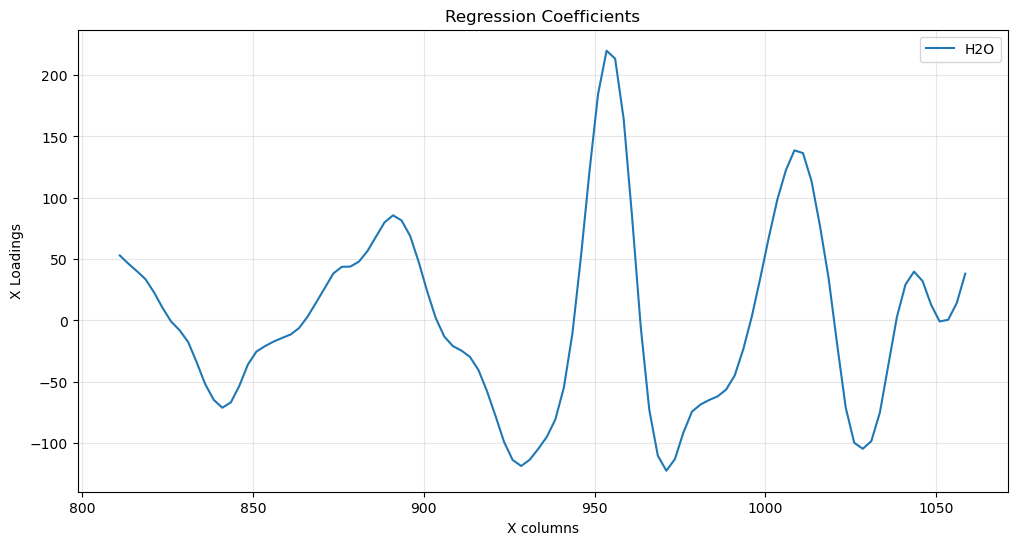

In [1338]:
for i, _label in enumerate(selected_labels):
    if label_to_display == _label:
        break
plt.plot(X.columns, pls2.best_estimator_.coef_[i], label=label_to_display)
plt.xlabel('X columns')
plt.ylabel('X Loadings')
plt.title('Regression Coefficients')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Final results

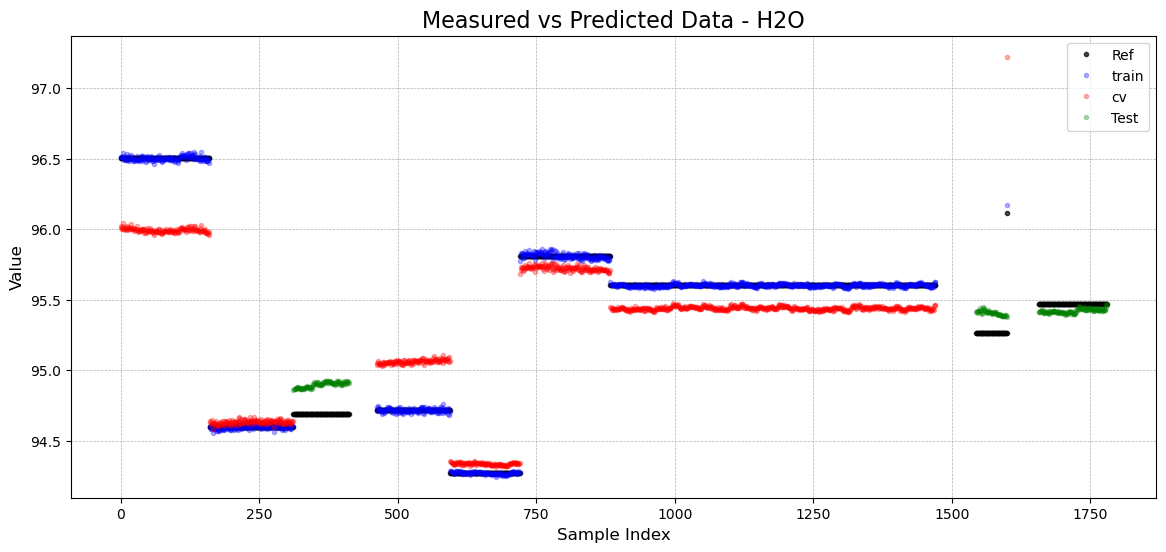

In [1339]:
plt.figure(figsize=(14, 6))

plt.plot(y_pls2_train.index, y_pls2_train[label_to_display],
         'ok', markersize=3, label=f"Ref", alpha=0.7)
plt.plot(y_test.index, y_test[label_to_display],
         'ok', markersize=3, alpha=0.7)
plt.plot(y_pls2_train.index, y_pred_train2[label_to_display],
         'ob', markersize=3, label=f"train", alpha=0.3)
plt.plot(y_pls2_train.index, y_pred_cv2[label_to_display],
         'or', markersize=3, label=f"cv", alpha=0.3)
plt.plot(y_test.index, y_pred_test2[label_to_display],
         'og', markersize=3, label=f"Test", alpha=0.3)

# Add title and labels
plt.title(f'Measured vs Predicted Data - {label_to_display}', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='best', fontsize=10)

plt.show()

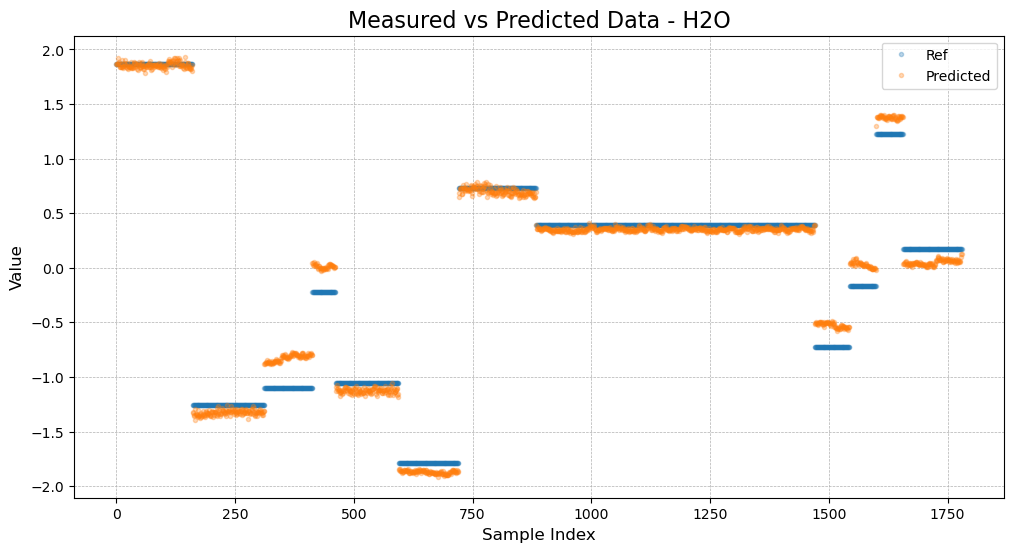

In [1340]:
for i, _label in enumerate(selected_labels):
    if label_to_display == _label:
        break
        
coeff = pls2.best_estimator_.coef_[i]
intercept = pls2.best_estimator_.intercept_[i]

y_measured = scale(y_filtered[label_to_display])

y_predicted = scale(X_filtered @ coeff.T + intercept)

plt.plot(y_filtered.index, y_measured, 'o', markersize=3, label="Ref", alpha=0.3)
plt.plot(X_filtered.index, y_predicted, 'o', markersize=3, label="Predicted", alpha=0.3)

# Add title and labels
plt.title(f'Measured vs Predicted Data - {label_to_display}', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='best', fontsize=10)
plt.show()

# Summary of the model

In [1341]:
dict = {'Ref' : [],
        'Train/Test': [],
        'Mean': [],
        'STD': [],
        'MAE': [],
        'Relative Error %': []}

results_df = pd.DataFrame(dict)

groups = ['Train', 'Test']
true_group_train_test = [y_pls2_train[label_to_display], y_test[label_to_display]]
pred_group_train_test = [y_pred_train2[label_to_display], y_pred_test2[label_to_display]]

for j, group in enumerate(groups):
    true_group = true_group_train_test[j]
    pred_group = pred_group_train_test[j]
    true_group_values = []
    predicted_group_values = []
    
    for i in np.unique(true_group):
        true_group_values.append(true_group.iloc[true_group.values == i])
        predicted_group_values.append(pred_group.iloc[true_group.values == i])
    
    for l, (true, predicted) in enumerate(zip(true_group_values, predicted_group_values)):
        true_mean = true.values.mean()
        if true_mean < 1:
            true_mean = 1
        results_df.loc[l] = [true.values.mean(), group, predicted.mean(), predicted.std(), mean_absolute_error(true, predicted),
                             mean_absolute_error(true, predicted)*100/np.abs(true_mean)]
        
print('\nFinal Results:')
print('---------------------')
display(results_df)

print('\n\n_________________________________________________________________\n')
display(results_df.describe())


Final Results:
---------------------


,Ref,Train/Test,Mean,STD,MAE,Relative Error %
0,94.689215,Test,94.897296,0.019165,0.208081,0.219752
1,95.263469,Test,95.407029,0.015620,0.143560,0.150698
2,95.467911,Test,95.420715,0.014738,0.047196,0.049437
3,95.602400,Train,95.602278,0.009389,0.007489,0.007833
4,95.811399,Train,95.810899,0.019500,0.015953,0.016651
5,96.113833,Train,96.170786,NaN,0.056953,0.059256
6,96.503100,Train,96.502553,0.015905,0.012539,0.012993




_________________________________________________________________



,Ref,Mean,STD,MAE,Relative Error %
count,7.000000,7.000000,6.000000,7.000000,7.000000
mean,95.635904,95.687365,0.015719,0.070253,0.073803
std,0.588149,0.531449,0.003667,0.076700,0.080968
min,94.689215,94.897296,0.009389,0.007489,0.007833
25%,95.365690,95.413872,0.014959,0.014246,0.014822
50%,95.602400,95.602278,0.015762,0.047196,0.049437
75%,95.962616,95.990843,0.018350,0.100257,0.104977
max,96.503100,96.502553,0.019500,0.208081,0.219752


# Deep Neural Networks

12/12 [==============================] - 0s 861us/step - loss: 68.5761 - mae: 8.2750
Test Loss: 68.57612609863281, Test MAE: 8.275026321411133
12/12 [==============================] - 0s 662us/step


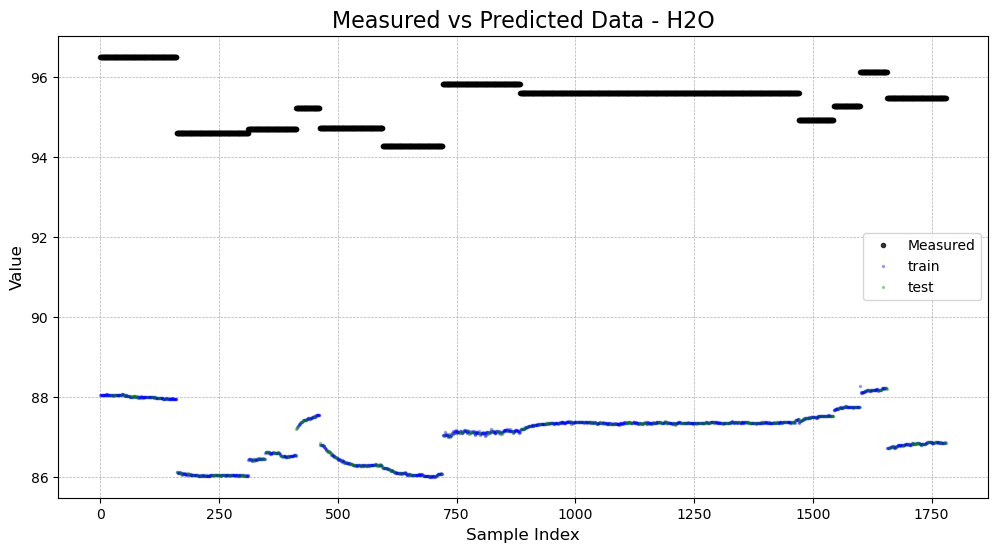

In [1342]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# For this example, let's generate some dummy data
N = chosen_X.shape[0] # Number of spectra
M = chosen_X.shape[1]   # Number of features (wavelengths)
K = 1#y_filtered[label_to_display]     # Number of concentration measurements

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(chosen_X, chosen_y[label_to_display], test_size=0.2, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(128, input_dim=M, activation='relu'))  # Input layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(K, activation='linear'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=400, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

plt.plot(y_train.index, y_train, 'ok', markersize=3, label=f"Measured", alpha=0.75)
plt.plot(y_test.index, y_test, 'ok', markersize=3, alpha=0.75)
plt.plot(y_train.index, y_pred_train, '.b', markersize=3, label=f"train", alpha=0.3) 
plt.plot(y_test.index, y_pred_test, '.g', markersize=3, label=f"test", alpha=0.3)

# Add title and labels
plt.title(f'Measured vs Predicted Data - {label_to_display}', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='best', fontsize=10)
plt.show()


Total number of groups of label "H2O" = 12
Total number of test groups = 3
Training fold 1
24/24 [==============================] - 0s 854us/step - loss: 39.9564 - mae: 6.0616
Fold 1 - Test Loss: 39.95644760131836, Test MAE: 6.061593532562256
24/24 [==============================] - 0s 604us/step
Predicted concentrations: [[85.14088 ]
 [85.198235]
 [85.219986]
 [85.26585 ]
 [85.3094  ]]
Actual concentrations: 312    94.689215
313    94.689215
314    94.689215
315    94.689215
316    94.689215
Name: H2O, dtype: float64


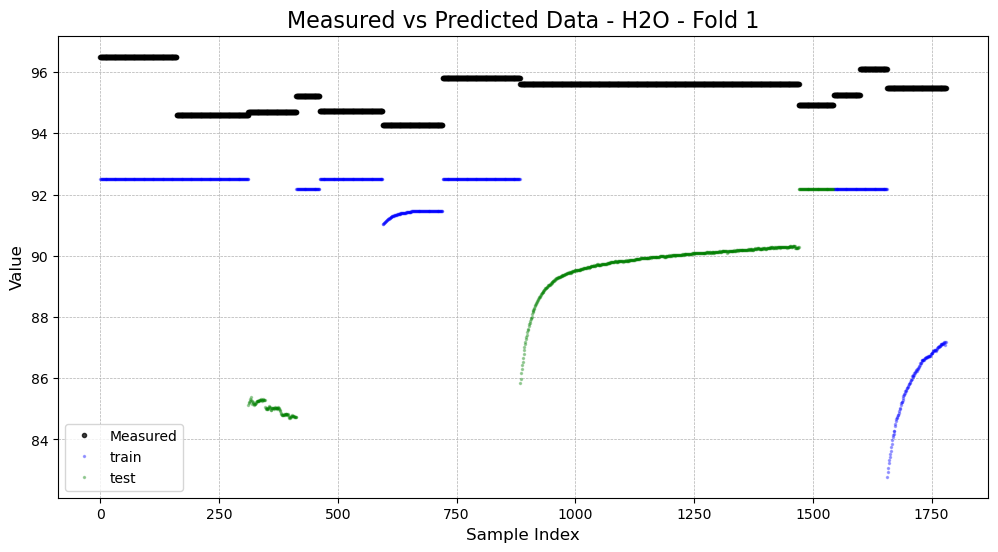

Training fold 2
25/25 [==============================] - 0s 969us/step - loss: 7.7703 - mae: 2.7764
Fold 2 - Test Loss: 7.77032470703125, Test MAE: 2.776383399963379
25/25 [==============================] - 0s 676us/step
Predicted concentrations: [[92.77069 ]
 [92.76841 ]
 [92.767235]
 [92.769554]
 [92.7683  ]]
Actual concentrations: 884    95.6024
885    95.6024
886    95.6024
887    95.6024
888    95.6024
Name: H2O, dtype: float64


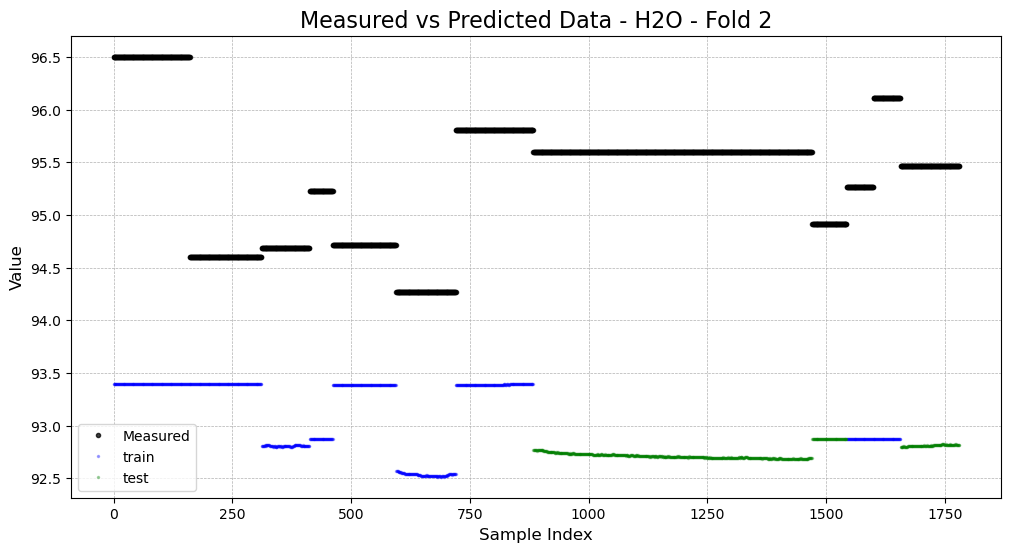

Training fold 3
23/23 [==============================] - 0s 843us/step - loss: 11.7815 - mae: 3.4187
Fold 3 - Test Loss: 11.781508445739746, Test MAE: 3.4186503887176514
23/23 [==============================] - 0s 863us/step
Predicted concentrations: [[92.18474]
 [92.17913]
 [92.17385]
 [92.17404]
 [92.16993]]
Actual concentrations: 884    95.6024
885    95.6024
886    95.6024
887    95.6024
888    95.6024
Name: H2O, dtype: float64


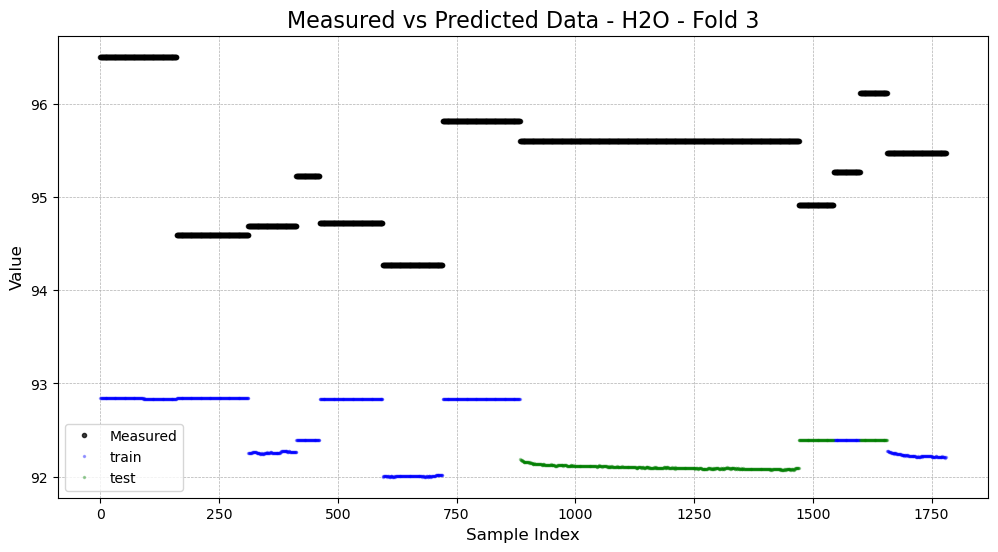

In [1343]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_filtered, y_filtered, and f_filtered are already defined
N = chosen_X.shape[0]  # Number of spectra
M = chosen_X.shape[1]  # Number of features (wavelengths)
K = 1  # Number of concentration measurements (assuming single output)

# Define group labels
groups = chosen_y[label_to_display]

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(chosen_X)


total_number_of_groups = chosen_y[group_by].nunique()
test_groups_ratio = 0.2
total_test_groups = int(np.ceil((test_groups_ratio)*total_number_of_groups)) 

print(f'Total number of groups of label "{group_by}" = {total_number_of_groups}')
print(f'Total number of test groups = {total_test_groups}')


# Define the Group K-Fold cross-validator
# gkf = GroupKFold(n_splits=total_test_groups)
gkf = GroupShuffleSplit(n_splits=total_test_groups)


# Define the model architecture function
def create_model():
    model = Sequential()
    model.add(Dense(256, input_dim=M, activation='relu'))  # Input layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(128, activation='sigmoid'))  # Hidden layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(64, activation='relu'))  # Hidden layer
    model.add(Dense(32, activation='relu'))  # Hidden layer
    model.add(Dense(K, activation='linear'))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Perform Group K-Fold cross-validation
fold_no = 1
for train_idx, test_idx in gkf.split(X_scaled, chosen_y[label_to_display], groups):
    print(f"Training fold {fold_no}")
    
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = chosen_y[label_to_display].iloc[train_idx], chosen_y[label_to_display].iloc[test_idx]
    
    model = create_model()
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"Fold {fold_no} - Test Loss: {loss}, Test MAE: {mae}")
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"Predicted concentrations: {y_pred_test[:5]}")
    print(f"Actual concentrations: {y_test[:5]}")

    plt.plot(y_train.index, y_train, 'ok', markersize=3, label=f"Measured", alpha=0.75)
    plt.plot(y_test.index, y_test, 'ok', markersize=3, alpha=0.75)
    plt.plot(y_train.index, y_pred_train, '.b', markersize=3, label=f"train", alpha=0.3) 
    plt.plot(y_test.index, y_pred_test, '.g', markersize=3, label=f"test", alpha=0.3)

    # Add title and labels
    plt.title(f'Measured vs Predicted Data - {label_to_display} - Fold {fold_no}', fontsize=16)
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    # Add grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add legend
    plt.legend(loc='best', fontsize=10)
    plt.show()

    fold_no += 1
